# MIE451/1513 Decision Support System -- Data Science Solution

## Be sure to let us know:
i. what location you chose (and remember to sign up on Piazza so there are no duplicates),

Calgary, Alberta

ii. what preprocessing steps you implemented

I only scraped reviews from hotels with >= 50 reviews, in order to have sufficient data for reaching valid conclusions. For these hotels, I further only sampled maximum 100 reviews. This provides a trade-off between data size and time to scrape data. I also verify there is no missing/empty hotel reviews

# Q1


In [1]:
%%capture
# installing useful libraries
!pip install folium
!pip install tqdm
!pip install numpy
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install scipy
!pip install geopy
!pip install tabulate
!pip install textblob
!pip install spacy
!python -m spacy download en_core_web_sm

In [2]:
# importing useful libraries

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

## Data Visualization
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde

## Geolocation
import geopy
from geopy.geocoders import Photon
from geopy.extra.rate_limiter import RateLimiter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-2-1b867c54f60b>:48: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [5]:
# setting pandas' display
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 500)

In [6]:
#Read in from pandas
columnNames = ['filePath','hotelName','reviewColumn','ratingScore','groundTruth',
               'date_stamp','streetAddress', 'City',
               'Province','postalCode']

hotelDf = pd.read_csv('reviews.csv',
                          header=None,
                          names=columnNames)

In [7]:
hotelDf = hotelDf[hotelDf['City'] == '(\'Calgary\',)']
hotelDf.reset_index(drop=True, inplace=True)
hotelDf.head()

filePath                                   hotelName                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         reviewColumn  ratingScore groundTruth       date_stamp         streetAddress          City Province postalCode
0  data\ca\154913\10202701\751826301.html  Calgary Airport Marriott In-Terminal Hotel   "Room 331. \nWe were moved from the Delta to the Marriott.\nWe were there March 24th when most flights were canceled. Covid19.\nConstant loud noise outside. Sounds like a jet outside but no planes were there. Still dont know what that was but it never stopped. Also could hear the vehicles driving around the tarmac. \nThe ac\u002Fheater would kick on very loud then slowly reduce.\nI am not one to ever give bad reviews but be warned don't ever stay in room 331.\nI would rather stay at the Delta.            2    negative   March 25, 2020  2008 Airport Road NE  ('Calgary',)  Alberta    T2E 3B9
1  data\ca\154913\10202701\752328687.html  Calgary Airport Marriott In-Terminal Hotel  "We were flying through Calgary on our way home from Mexico during the Covid-19 outbreak.\n\nWe had originally booked the Delta but we were contacted by the manager and moved to the newer Marriott In-Terminal hotel. \n\nIt is a beautiful new hotel set right in the terminal. We arrived that the staff took exceptional care to ensure proper safety standards were being met.\n\nAfter a quick check in we stopped to place an order at the restaurant to take to our room. It was ready very quickly and...            5    positive    April 6, 2020  2008 Airport Road NE  ('Calgary',)  Alberta    T2E 3B9
2  data\ca\154913\10202701\759771534.html  Calgary Airport Marriott In-Terminal Hotel  "I had a one day layover waiting for an international flight.  I was shocked when I walked from the terminal straight to the reception desk.  They quickly issued the room key, and went to the room.  The windows faced the airport itself, quite busy.  If you are a light sleeper, maybe you may want a room away from the airport operations, the noise didn't bother me at all.  The Wi-Fi, worked well, however there are fees for the use of the amenity.  Food was well prepared and fresh, room service...            5    positive    July 12, 2020  2008 Airport Road NE  ('Calgary',)  Alberta    T2E 3B9
3  data\ca\154913\10202701\763272806.html  Calgary Airport Marriott In-Terminal Hotel                                                                                                                    "Stayed one night at the height of the pandemic; no services whatsoever at the hotel and everything in the terminal closed. So, what was I to do for a coffee at 5:30 in the morning? Went to reception, asked for a coffee and the girl went somewhere in the back - 3 minutes later I had my coffee.\nIt wasn't specialty coffee, wasn't very hot - but I did appreciate the effort. Thank you.            5    positive   August 5, 2020  2008 Airport Road NE  ('Calgary',)  Alberta    T2E 3B9
4  data\ca\154913\10202701\767154737.html  Calgary Airport Marriott In-Terminal Hotel                                                                                                                                                                                                                       "Worked well when our carrier changed our flight.  The room was very expensive ($321.00), considering we were looking at a parking lot(s).  Room service: -2 cheeseburger platters and  1lb of wings with two pop (no booze) and 2 desserts was $80 freaking dollars. Will not stay here again            2    negat

In [8]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf

    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [9]:
hotelDf.columns

Index(['filePath', 'hotelName', 'reviewColumn', 'ratingScore', 'groundTruth',
       'date_stamp', 'streetAddress', 'City', 'Province', 'postalCode'],
      dtype='object')

In [10]:
reviews = hotelDf['reviewColumn'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])
reviewDF.head()

100%|██████████| 3391/3391 [00:05<00:00, 670.33it/s]


reviewCol   vader
0   "Room 331. \nWe were moved from the Delta to the Marriott.\nWe were there March 24th when most flights were canceled. Covid19.\nConstant loud noise outside. Sounds like a jet outside but no planes were there. Still dont know what that was but it never stopped. Also could hear the vehicles driving around the tarmac. \nThe ac\u002Fheater would kick on very loud then slowly reduce.\nI am not one to ever give bad reviews but be warned don't ever stay in room 331.\nI would rather stay at the Delta. -0.8152
1  "We were flying through Calgary on our way home from Mexico during the Covid-19 outbreak.\n\nWe had originally booked the Delta but we were contacted by the manager and moved to the newer Marriott In-Terminal hotel. \n\nIt is a beautiful new hotel set right in the terminal. We arrived that the staff took exceptional care to ensure proper safety standards were being met.\n\nAfter a quick check in we stopped to place an order at the restaurant to take to our room. It was ready very quickly and...  0.9945
2  "I had a one day layover waiting for an international flight.  I was shocked when I walked from the terminal straight to the reception desk.  They quickly issued the room key, and went to the room.  The windows faced the airport itself, quite busy.  If you are a light sleeper, maybe you may want a room away from the airport operations, the noise didn't bother me at all.  The Wi-Fi, worked well, however there are fees for the use of the amenity.  Food was well prepared and fresh, room service...  0.9245
3                                                                                                                    "Stayed one night at the height of the pandemic; no services whatsoever at the hotel and everything in the terminal closed. So, what was I to do for a coffee at 5:30 in the morning? Went to reception, asked for a coffee and the girl went somewhere in the back - 3 minutes later I had my coffee.\nIt wasn't specialty coffee, wasn't very hot - but I did appreciate the effort. Thank you.  0.7351
4                                                                                                                                                                                                                       "Worked well when our carrier changed our flight.  The room was very expensive ($321.00), considering we were looking at a parking lot(s).  Room service: -2 cheeseburger platters and  1lb of wings with two pop (no booze) and 2 desserts was $80 freaking dollars. Will not stay here again -0.1779

In [11]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values

    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)

    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    print(finalreviewDf.shape)
    print(hotelDf.shape)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [12]:
# Right now, we don't care about top k words
finaldf = dataFrameTransformation(hotelDf, reviewDF, [])
finaldf.head()

(3391, 2)
(3391, 10)


hotelName  ratingScore groundTruth                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            reviewCol   vader
0  Calgary Airport Marriott In-Terminal Hotel            2    negative   "Room 331. \nWe were moved from the Delta to the Marriott.\nWe were there March 24th when most flights were canceled. Covid19.\nConstant loud noise outside. Sounds like a jet outside but no planes were there. Still dont know what that was but it never stopped. Also could hear the vehicles driving around the tarmac. \nThe ac\u002Fheater would kick on very loud then slowly reduce.\nI am not one to ever give bad reviews but be warned don't ever stay in room 331.\nI would rather stay at the Delta. -0.8152
1  Calgary Airport Marriott In-Terminal Hotel            5    positive  "We were flying through Calgary on our way home from Mexico during the Covid-19 outbreak.\n\nWe had originally booked the Delta but we were contacted by the manager and moved to the newer Marriott In-Terminal hotel. \n\nIt is a beautiful new hotel set right in the terminal. We arrived that the staff took exceptional care to ensure proper safety standards were being met.\n\nAfter a quick check in we stopped to place an order at the restaurant to take to our room. It was ready very quickly and...  0.9945
2  Calgary Airport Marriott In-Terminal Hotel            5    positive  "I had a one day layover waiting for an international flight.  I was shocked when I walked from the terminal straight to the reception desk.  They quickly issued the room key, and went to the room.  The windows faced the airport itself, quite busy.  If you are a light sleeper, maybe you may want a room away from the airport operations, the noise didn't bother me at all.  The Wi-Fi, worked well, however there are fees for the use of the amenity.  Food was well prepared and fresh, room service...  0.9245
3  Calgary Airport Marriott In-Terminal Hotel            5    positive                                                                                                                    "Stayed one night at the height of the pandemic; no services whatsoever at the hotel and everything in the terminal closed. So, what was I to do for a coffee at 5:30 in the morning? Went to reception, asked for a coffee and the girl went somewhere in the back - 3 minutes later I had my coffee.\nIt wasn't specialty coffee, wasn't very hot - but I did appreciate the effort. Thank you.  0.7351
4  Calgary Airport Marriott In-Terminal Hotel            2    negative                                                                                                                                                                                                                       "Worked well when our carrier changed our flight.  The room was very expensive ($321.00), considering we were looking at a parking lot(s).  Room service: -2 cheeseburger platters and  1lb of wings with two pop (no booze) and 2 desserts was $80 freaking dollars. Will not stay here again -0.1779

## Q1a

In [13]:
avg_df = finaldf[['hotelName', 'vader', 'ratingScore', 'reviewCol']].groupby('hotelName').agg({
    'vader': ['mean', 'median'],
    'ratingScore': 'mean',
    'reviewCol': 'count'
})
avg_df.columns = ['avg_vader', 'median_vader', 'avg_ratingScore', 'total_reviews']
avg_df.head()

avg_vader  median_vader  avg_ratingScore  total_reviews
hotelName                                                                                       
Acclaim Hotel Calgary Airport             0.705338       0.92825         4.190000            100
Alt Hotel Calgary East Village            0.821145       0.94880         4.441558             77
Amenida Residences                        0.655677       0.92055         3.640000            100
Best Western Plus Calgary Centre Inn      0.755501       0.93980         4.460000            100
Best Western Plus Port O&#39;Call Hotel   0.623664       0.91605         3.800000            100

## Q1b

In [14]:
avg_df.nlargest(5, 'avg_vader')

avg_vader  median_vader  avg_ratingScore  total_reviews
hotelName                                                                                                                     
Residence Inn by Marriott Calgary Downtown / Beltline District          0.875744       0.95965             4.55            100
Delta Hotels by Marriott Calgary Downtown                               0.842587       0.96100             4.42            100
Wicked Hostels - Calgary                                                0.840504       0.95155             4.10            100
Holiday Inn &amp; Suites Calgary South - Conference Ctr, an IHG Hotel   0.836648       0.95225             4.50            100
The Westin Calgary                                                      0.823325       0.93915             4.11            100

In [15]:
avg_df.nlargest(5, 'median_vader')

avg_vader  median_vader  avg_ratingScore  total_reviews
hotelName                                                                                                              
Delta Hotels by Marriott Calgary Downtown                        0.842587       0.96100             4.42            100
Residence Inn by Marriott Calgary Downtown / Beltline District   0.875744       0.95965             4.55            100
Le Germain Hotel Calgary                                         0.807140       0.95760             4.50            100
Sandman Signature Calgary Airport Hotel                          0.817010       0.95750             4.24             50
Delta Hotels by Marriott Calgary South                           0.715409       0.95590             4.08            100

In [16]:
avg_df.nlargest(5, 'avg_ratingScore')

avg_vader  median_vader  avg_ratingScore  total_reviews
hotelName                                                                                                                     
Residence Inn by Marriott Calgary Downtown / Beltline District          0.875744       0.95965             4.55            100
Hotel Blackfoot                                                         0.799834       0.95440             4.53            100
Holiday Inn &amp; Suites Calgary South - Conference Ctr, an IHG Hotel   0.836648       0.95225             4.50            100
Le Germain Hotel Calgary                                                0.807140       0.95760             4.50            100
Best Western Plus Calgary Centre Inn                                    0.755501       0.93980             4.46            100

n largest generally agree. Hotels with highest vader have avg rating around 4.5/5, which is good. Likewise, hotels with highest avg rating have vader score arounf 0.8-0.9, which is also good. 2 hotels appear in both avg_rating and avg_vader, so there is good agreement. The same argument applies to median vader.

In [17]:
avg_df.nsmallest(5, 'avg_vader')

avg_vader  median_vader  avg_ratingScore  total_reviews
hotelName                                                                                                                            
Canadas Best Value Inn Calgary Chinook Station                                -0.191095      -0.47500             1.68            100
Holiday Inn Express &amp; Suites Calgary South-Macleod Trail S, an IHG Hotel   0.284454       0.78490             2.87            100
Hyatt Place Calgary Airport                                                    0.355477       0.76855             3.30            100
Econo Lodge Motel Village                                                      0.364013       0.76690             2.67            100
Econo Lodge Inn &amp; Suites University                                        0.462118       0.84110             3.12            100

In [18]:
avg_df.nsmallest(5, 'median_vader')

avg_vader  median_vader  avg_ratingScore  total_reviews
hotelName                                                                                                                            
Canadas Best Value Inn Calgary Chinook Station                                -0.191095      -0.47500             1.68            100
Econo Lodge Motel Village                                                      0.364013       0.76690             2.67            100
Hyatt Place Calgary Airport                                                    0.355477       0.76855             3.30            100
Holiday Inn Express &amp; Suites Calgary South-Macleod Trail S, an IHG Hotel   0.284454       0.78490             2.87            100
Econo Lodge Inn &amp; Suites University                                        0.462118       0.84110             3.12            100

In [19]:
avg_df.nsmallest(5, 'avg_ratingScore')

avg_vader  median_vader  avg_ratingScore  total_reviews
hotelName                                                                                                                            
Canadas Best Value Inn Calgary Chinook Station                                -0.191095      -0.47500             1.68            100
Econo Lodge Motel Village                                                      0.364013       0.76690             2.67            100
Holiday Inn Express &amp; Suites Calgary South-Macleod Trail S, an IHG Hotel   0.284454       0.78490             2.87            100
Econo Lodge Inn &amp; Suites University                                        0.462118       0.84110             3.12            100
Hyatt Place Calgary Airport                                                    0.355477       0.76855             3.30            100

There is very good agreement here. Each method gives the exact same 5 hotels; just in different orders. We have proof that both mean and average vader score are good measures of the best and worst hotels.

# Q2

In [20]:
# setting default parameters of WordCloud object
wordcloud_args = dict(
    width = 800,
    height = 800,
    background_color ='white',
    min_font_size = 10,
    )

# function to plot word cloud
def plotWordCloud(dictionary, **kwargs):
    wordcloud = WordCloud(**kwargs)

    wordcloud.generate_from_frequencies(dict(dictionary))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [21]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    return stop

def getTopKWords(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update([word.lower()
                            for word
                            in re.findall(r'\w+', review)
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

def getTopK(df, kwords, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
  stop = get_stop_words()
  counter = Counter()
  reviews = df.loc[operation(df[label_column],label_value)][value_column]
  for review in reviews:
        counter.update([word.lower()
                        for word
                        in re.findall(r'\w+', review)
                        if word.lower() not in stop and len(word) > 2])
  topk = counter.most_common(kwords)
  return topk

## Q2a

In [22]:
#We are only intereseted in this three column for overall analysis
itemAnalysisDf = finaldf[['reviewCol','groundTruth','vader']]
itemAnalysisDf.head()

reviewCol groundTruth   vader
0   "Room 331. \nWe were moved from the Delta to the Marriott.\nWe were there March 24th when most flights were canceled. Covid19.\nConstant loud noise outside. Sounds like a jet outside but no planes were there. Still dont know what that was but it never stopped. Also could hear the vehicles driving around the tarmac. \nThe ac\u002Fheater would kick on very loud then slowly reduce.\nI am not one to ever give bad reviews but be warned don't ever stay in room 331.\nI would rather stay at the Delta.    negative -0.8152
1  "We were flying through Calgary on our way home from Mexico during the Covid-19 outbreak.\n\nWe had originally booked the Delta but we were contacted by the manager and moved to the newer Marriott In-Terminal hotel. \n\nIt is a beautiful new hotel set right in the terminal. We arrived that the staff took exceptional care to ensure proper safety standards were being met.\n\nAfter a quick check in we stopped to place an order at the restaurant to take to our room. It was ready very quickly and...    positive  0.9945
2  "I had a one day layover waiting for an international flight.  I was shocked when I walked from the terminal straight to the reception desk.  They quickly issued the room key, and went to the room.  The windows faced the airport itself, quite busy.  If you are a light sleeper, maybe you may want a room away from the airport operations, the noise didn't bother me at all.  The Wi-Fi, worked well, however there are fees for the use of the amenity.  Food was well prepared and fresh, room service...    positive  0.9245
3                                                                                                                    "Stayed one night at the height of the pandemic; no services whatsoever at the hotel and everything in the terminal closed. So, what was I to do for a coffee at 5:30 in the morning? Went to reception, asked for a coffee and the girl went somewhere in the back - 3 minutes later I had my coffee.\nIt wasn't specialty coffee, wasn't very hot - but I did appreciate the effort. Thank you.    positive  0.7351
4                                                                                                                                                                                                                       "Worked well when our carrier changed our flight.  The room was very expensive ($321.00), considering we were looking at a parking lot(s).  Room service: -2 cheeseburger platters and  1lb of wings with two pop (no booze) and 2 desserts was $80 freaking dollars. Will not stay here again    negative -0.1779

In [23]:
topkGroundPos = getTopK(itemAnalysisDf, 50, label_value='positive')
topkGroundPos[:10]

[('great', 1479),
 ('clean', 1315),
 ('good', 1163),
 ('breakfast', 1090),
 ('calgary', 940),
 ('nice', 910),
 ('friendly', 877),
 ('would', 743),
 ('comfortable', 718),
 ('stayed', 680)]

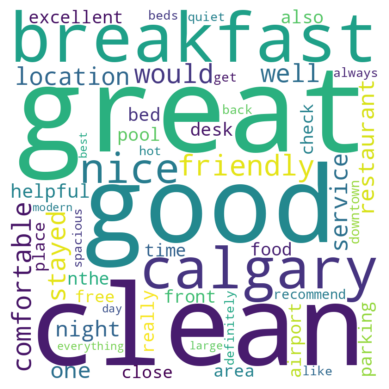

In [24]:
plotWordCloud(dict(topkGroundPos), **wordcloud_args)

In [25]:
topkGroundNeg = getTopK(itemAnalysisDf, 50, label_value='negative')
topkGroundNeg[:10]

[('would', 550),
 ('desk', 458),
 ('u2019t', 454),
 ('front', 445),
 ('one', 417),
 ('night', 414),
 ('breakfast', 390),
 ('good', 341),
 ('get', 338),
 ('told', 334)]

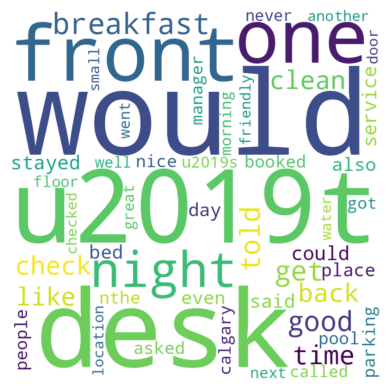

In [26]:
plotWordCloud(dict(topkGroundNeg), **wordcloud_args)

In [27]:
# common
pos_set = set([term for (term,freq) in topkGroundPos])
neg_set = set([term for (term,freq) in topkGroundNeg])
print(list(pos_set.intersection(neg_set)))
print(len(list(pos_set.intersection(neg_set))))

['desk', 'well', 'time', 'check', 'would', 'service', 'location', 'friendly', 'pool', 'night', 'clean', 'nice', 'front', 'breakfast', 'back', 'stayed', 'place', 'also', 'get', 'day', 'good', 'calgary', 'great', 'parking', 'bed', 'nthe', 'one', 'like']
28


In [28]:
# location-specific
print("The following terms are in ground truth positive only")
pos_only = pos_set - neg_set
print(list(pos_only))
print("The following terms are in ground truth negative only")
neg_only = neg_set - pos_set
print(list(neg_only))

The following terms are in ground truth positive only
['airport', 'everything', 'comfortable', 'quiet', 'food', 'downtown', 'beds', 'really', 'helpful', 'spacious', 'free', 'modern', 'always', 'restaurant', 'close', 'definitely', 'hot', 'best', 'large', 'area', 'excellent', 'recommend']
The following terms are in ground truth negative only
['booked', 'even', 'people', 'u2019s', 'morning', 'told', 'never', 'door', 'said', 'next', 'called', 'manager', 'checked', 'another', 'floor', 'u2019t', 'asked', 'water', 'could', 'went', 'got', 'small']


I am not surprised by these results. The ones that are common are mostly nouns, things like breakfast, front desk, and service; ie things that can be either good or bad. There are also alot of adjectives in common if those adjectives can be switched easily in sentiment with 'not'. For example, 'good' is common in both lists; but this is because for a negative review, we can just say 'not good'. Words that are in each list clearly belong to those lists. For example, comfortable and spacious are usually only mentioned for positive reviews and 'small' would make sense to appear more in negative reviews.

## Q2b

In [29]:
grammar2 = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns

    NP:
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [30]:
chunker = nltk.RegexpParser(grammar2)
tagger = PerceptronTagger()
pos_tag = tagger.tag

In [31]:
# to make the results more useable, we clean up the tree results shown above.
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()

# generator, create item one a time
def get_terms(tree, remove_stopwords=True):
    for leaf in leaves(tree):

        term = []

        for w, t in leaf:
            if remove_stopwords:
                if acceptable_word(w):
                    term.append(normalise(w))

            else:
                term.append(normalise(w))

        # Phrase only
        if len(term) > 1:
            yield term

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case...
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        if len(token) > 0: # don't return empty tokens
            finalList.append(token.rstrip())
    return finalList

In [32]:
# getting top noun phrases
def getTopKNP(df, kNPs, label_value, chunker, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):

    counter = Counter()
    reviews = df.loc[operation(df[label_column],label_value)][value_column]

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))
                            ]))
    topk = counter.most_common(kNPs)
    return topk


def NPdataFrameTransformation(hotelDf, reviewDF, topk, chunker):
    reviews = reviewDF['reviewCol'].values

    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten_phrase_lists([word
                                       for word
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)


    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [33]:
topk_nounphrase_groundpos = getTopKNP(itemAnalysisDf, 50, 'positive', chunker)
topk_nounphrase_groundpos[:10]

[('lot hotel', 9),
 ('calgari busi', 9),
 ('restaur site', 7),
 ('coupl day', 7),
 ('lot option', 7),
 ('night calgari', 6),
 ('walk shower', 6),
 ('lot restaur', 6),
 ('calgari airport marriott termin', 5),
 ('plenti space', 5)]

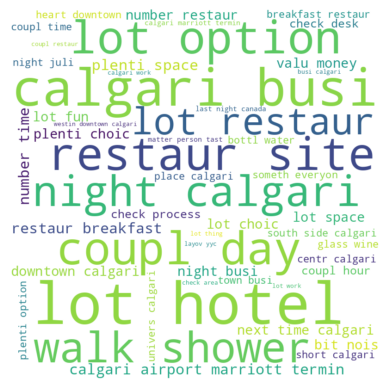

In [34]:
plotWordCloud(dict(topk_nounphrase_groundpos), **wordcloud_args)

In [35]:
topk_nounphrase_groundneg = getTopKNP(itemAnalysisDf, 50, 'negative', chunker)
topk_nounphrase_groundneg[:10]

[('lot peopl', 6),
 ('night calgari', 6),
 ('lot nois', 6),
 ('sister law', 5),
 ('manag duti', 4),
 ('lot time', 4),
 ('time check', 4),
 ('check time', 4),
 ('month advanc', 3),
 ('cup coffe', 3)]

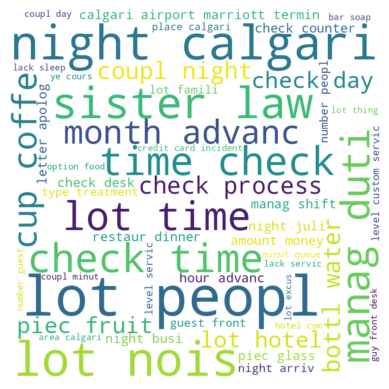

In [36]:
plotWordCloud(dict(topk_nounphrase_groundneg), **wordcloud_args)

In [37]:
# common
pos_set = list([term for (term,freq) in topk_nounphrase_groundpos])
neg_set = list([term for (term,freq) in topk_nounphrase_groundneg])
print([x for x in pos_set if x in neg_set])

['lot hotel', 'coupl day', 'night calgari', 'calgari airport marriott termin', 'night busi', 'check process', 'check desk', 'place calgari', 'bottl water', 'night juli', 'lot thing']


In [38]:
# location-specific
print("The following noun phrases are in ground truth positive only")
pos_only = [x for x in pos_set if x not in neg_set]
print(list(pos_only))
print("The following noun phrases are in ground truth negative only")
neg_only = [x for x in neg_set if x not in pos_set]
print(list(neg_only))

The following noun phrases are in ground truth positive only
['calgari busi', 'restaur site', 'lot option', 'walk shower', 'lot restaur', 'plenti space', 'restaur breakfast', 'number time', 'bit nois', 'lot choic', 'next time calgari', 'plenti choic', 'downtown calgari', 'lot space', 'lot fun', 'number restaur', 'valu money', 'coupl hour', 'south side calgari', 'centr calgari', 'glass wine', 'breakfast restaur', 'short calgari', 'someth everyon', 'heart downtown', 'plenti option', 'town busi', 'univers calgari', 'coupl time', 'calgari marriott termin', 'matter person tast', 'last night canada', 'westin downtown calgari', 'layov yyc', 'check area', 'coupl restaur', 'calgari work', 'busi calgari', 'lot work']
The following noun phrases are in ground truth negative only
['lot peopl', 'lot nois', 'sister law', 'manag duti', 'lot time', 'time check', 'check time', 'month advanc', 'cup coffe', 'coupl night', 'piec fruit', 'check day', 'piec glass', 'hour advanc', 'manag shift', 'amount money

Do any noun phrases appear in both positive and negative reviews? \\
yes. generic phrases used to describe a person's stay, like 'couple days' and 'night in calgary' are included in both.

Identify a noun phrase you did not expect to see in the positive reviews and explain why it may be there \\
I see 'bit noisy' in the positive reviews, which initially surprised me because I thought positive reviews shouldn't complain about noise. However, it makes sense because people could say 'The hotel was a bit noisy, however, blah blah blah'.

## Q2c

In [39]:
revised_grammar = r"""
    NBAR:
        {<JJ.*><NN.*>}  # At least one Adjective followed by Nouns

    NP:
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [40]:
revised_chunker = nltk.RegexpParser(revised_grammar)
revised_tagger = PerceptronTagger()
revised_pos_tag = revised_tagger.tag

In [41]:
topk_revisednounphrase_groundpos = getTopKNP(itemAnalysisDf, 50, 'positive', revised_chunker)
topk_revisednounphrase_groundpos[:10]

[('new comfort', 2),
 ('larger runway view', 1),
 ('comfort modern decor', 1),
 ('friendli outstand servic', 1),
 ('comfort great shower', 1),
 ('nlocat nthe element', 1),
 ('nice option like avacado toast', 1),
 ('littl perk like filter water', 1),
 ('comfort small kitchen', 1),
 ('clean design nthe', 1)]

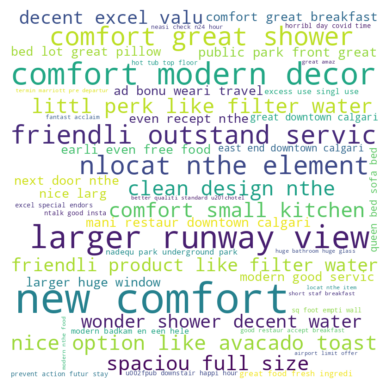

In [42]:
plotWordCloud(dict(topk_revisednounphrase_groundpos), **wordcloud_args)

In [43]:
topk_revisednounphrase_groundneg = getTopKNP(itemAnalysisDf, 50, 'negative', revised_chunker)
topk_revisednounphrase_groundneg[:10]

[('termin conveni earli morn', 1),
 ('long strand black hair', 1),
 ('littl sparser last time', 1),
 ('place club level', 1),
 ('much nicer price', 1),
 ('big truck outsid park', 1),
 ('fair amount homeless peopl', 1),
 ('good hotel around downtown calgari', 1),
 ('quit fast complimentari servic', 1),
 ('awkward bathroom nthe', 1)]

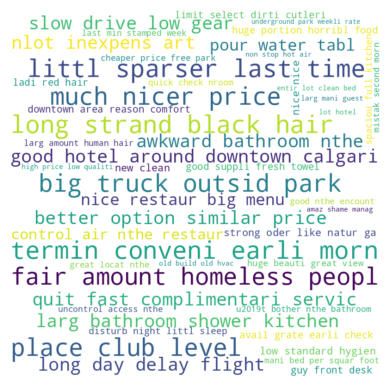

In [44]:
plotWordCloud(dict(topk_revisednounphrase_groundneg), **wordcloud_args)

In [45]:
# common
pos_set = [term for (term,freq) in topk_revisednounphrase_groundpos]
neg_set = [term for (term,freq) in topk_revisednounphrase_groundneg]
print([x for x in pos_set if x in neg_set])

[]


In [46]:
# location-specific
print("The following noun phrases are in ground truth positive only")
pos_only = [x for x in pos_set if x not in neg_set]
print(pos_only)
print("The following noun phrases are in ground truth negative only")
neg_only = [x for x in neg_set if x not in pos_set]
print(neg_only)

The following noun phrases are in ground truth positive only
['new comfort', 'larger runway view', 'comfort modern decor', 'friendli outstand servic', 'comfort great shower', 'nlocat nthe element', 'nice option like avacado toast', 'littl perk like filter water', 'comfort small kitchen', 'clean design nthe', 'spaciou full size', 'friendli product like filter water', 'wonder shower decent water', 'decent excel valu', 'mani restaur downtown calgari', 'public park front great', 'modern good servic', 'bed lot great pillow', 'next door nthe', 'larger huge window', 'ad bonu weari travel', 'nice larg', 'comfort great breakfast', 'even recept nthe', 'earli even free food', 'east end downtown calgari', 'great downtown calgari', 'queen bed sofa bed', 'great food fresh ingredi', 'excess use singl use', 'nadequ park underground park', 'modern badkam en een hele', 'u002fpub downstair happi hour', 'sq foot empti wall', 'horribl day covid time', 'ntalk good insta', 'prevent action futur stay', 'excel

 Note at least 3 observations on the similarities or differences between these noun phrases and those in Q2(b). \\
 1. the intersection between positive and negative list is empty! This is because these are adjective phrases now, and adjectives usually correspond to positive or negative. \\
 2. This parsing gives longer and more descriptive results, like 'good hotel around downtown calgari' \\
 3. we get more descriptive adjective. before we had mostly things like 'lot' and 'bit'. Now that we only focus on adjectives, we get words like 'new', 'larger', 'comfort', 'friendly' that are more obviously positive. \\

Which pattern do you think is more effective for sentiment
analysis and why?
I think the adjective phrase is more effective, because there is a clear distinction, ie the intersection is the empty set. The adjective phrases reveal more nuanced terms people use, as opposed to simply 'lots' that we see a lot in noun phrases. These adjectives phrases are often clearly positive or negative, so there existence in a review is a more clear-cut indication of a binary sentiment.

# Q3

## Q3a

In [47]:
hotelDf.columns

Index(['filePath', 'hotelName', 'reviewColumn', 'ratingScore', 'groundTruth',
       'date_stamp', 'streetAddress', 'City', 'Province', 'postalCode'],
      dtype='object')

In [48]:
topk = getTopKWords(reviewDF, 50)
finaldfK = dataFrameTransformation(hotelDf, reviewDF, topk)
finaldfK.head()

(3391, 52)
(3391, 10)


hotelName  ratingScore groundTruth                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            reviewCol   vader  great  clean  good  breakfast  would  calgary  nice  friendly  one  stayed  night  desk  front  service  well  comfortable  location  bed  time  also  restaurant  pool  u2019t  check  get  parking  nthe  place  airport  back  helpful  like  really  could  food  area  day  even  free  close  recommend  hot  excellent  next  beds  downtown  u2019s  floor  told  people
0  Calgary Airport Marriott In-Terminal Hotel            2    negative   "Room 331. \nWe were moved from the Delta to the Marriott.\nWe were there March 24th when most flights were canceled. Covid19.\nConstant loud noise outside. Sounds like a jet outside but no planes were there. Still dont know what that was but it never stopped. Also could hear the vehicles driving around the tarmac. \nThe ac\u002Fheater would kick on very loud then slowly reduce.\nI am not one to ever give bad reviews but be warned don't ever stay in room 331.\nI would rather stay at the Delta. -0.8152      0      0     0          0      1        0     0         0    1       0      0     0      0        0     0            0         0    0     0     1           0     0       0      0    0        0     1      0        0     0        0     1       0      1     0     0    0     0     0      0          0    0          0     0     0         0       0      0     0       0
1  Calgary Airport Marriott In-Terminal Hotel            5    positive  "We were flying through Calgary on our way home from Mexico during the Covid-19 outbreak.\n\nWe had originally booked the Delta but we were contacted by the manager and moved to the newer Marriott In-Terminal hotel. \n\nIt is a beautiful new hotel set right in the terminal. We arrived that the staff took exceptional care to ensure proper safety standards were being met.\n\nAfter a quick check in we stopped to place an order at the restaurant to take to our room. It was ready very quickly and...  0.9945      0      0     0          0      0        1     1         0    0       0      0     0      0        0     1            1         0    0     0     0           1     0       0      1    0        0     1      1        0     0        0     1       0      0     1     0    0     0     1      0          0    0          0     0     1         0       0      0     0       0
2  Calgary Airport Marriott In-Terminal Hotel            5    positive  "I had a one day layover waiting for an international flight.  I was shocked when I walked from the terminal straight to the reception desk.  They quickly issued the room key, and went to the room.  The windows faced the airport itself, quite busy.  If you are a light sleeper, maybe you may want a room away from the airport operations, the noise didn't bother me at all.  The Wi-Fi, worked well, however there are fees for the use of the amenity.  Food was well prepared and fresh, room service...  0.9245      0      0     0          0      0        0     1         0    1       0      0     1      0        1     1            0         1    0     0     1           0     1       0      1    1        0     0      0        1     0        0     0       0      0     1     0    1     0     0      0          0    0          0     0     0         0       0      0     0       0
3  Calgary Airport Marriott In-Terminal Hotel            5    positive                                                                                                                    "Stayed one night at the height of the pandemic; n

In [49]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [50]:
miScoredf = getMI(topk, finaldfK)

In [51]:
miScoredf.head()

Word  MI Score
48         told  0.058308
0         great  0.039084
42    excellent  0.024489
1         clean  0.024348
15  comfortable  0.022588

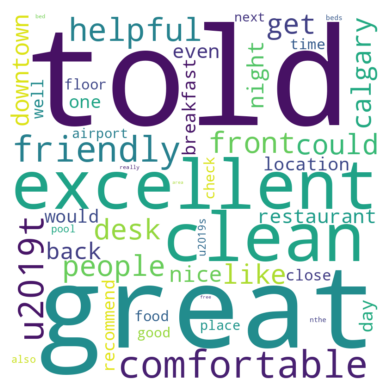

In [52]:
plotWordCloud(miScoredf.set_index('Word')['MI Score'].to_dict(), **wordcloud_args)

Which words get the highest MI values? Does this make sense? \\
Words like excellent, clean, great, comfortable, get high MI values. This makes sense because each one of the words with high MI are closer to eithre a clear positive or clear negative sentiment. In our case, clean, comfortable etc are positive. We notice that we mostly see positive words. This is potentially because most reviews are positive. Ie average rating of a restaurant is closer to 5 than to 1.

## Q3b

In [53]:
# getting top noun phrases
def getTopKNP(df, kNPs, chunker):

    counter = Counter()
    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))
                            ]))
    topk = counter.most_common(kNPs)
    return topk

In [54]:
topkNP = getTopKNP(reviewDF, 50, revised_chunker)
finaldfKNP = NPdataFrameTransformation(hotelDf, reviewDF, topkNP, revised_chunker)
finaldfKNP.head()

hotelName  ratingScore groundTruth                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            reviewCol   vader  new comfort  termin conveni earli morn  larger runway view  long strand black hair  littl sparser last time  place club level  comfort modern decor  friendli outstand servic  much nicer price  comfort great shower  nlocat nthe element  nice option like avacado toast  littl perk like filter water  comfort small kitchen  clean design nthe  spaciou full size  big truck outsid park  friendli product like filter water  wonder shower decent water  decent excel valu  mani restaur downtown calgari  public park front great  modern good servic  bed lot great pillow  next door nthe  larger huge window  ad bonu weari travel  fair amount homeless peopl  nice larg  good hotel around downtown calgari  comfort great breakfast  even recept nthe  earli even free food  east end downtown calgari  great downtown calgari  queen bed sofa bed  great food fresh ingredi  quit fast complimentari servic  awkward bathroom nthe  excess use singl use  nadequ park underground park  modern badkam en een hele  larg bathroom shower kitchen  u002fpub downstair happi hour  sq foot empti wall  slow drive low gear  horribl day covid time  ntalk good insta  prevent action futur stay  long day delay flight
0  Calgary Airport Marriott In-Terminal Hotel            2    negative   "Room 331. \nWe were moved from the Delta to the Marriott.\nWe were there March 24th when most flights were canceled. Covid19.\nConstant loud noise outside. Sounds like a jet outside but no planes were there. Still dont know what that was but it never stopped. Also could hear the vehicles driving around the tarmac. \nThe ac\u002Fheater would kick on very loud then slowly reduce.\nI am not one to ever give bad reviews but be warned don't ever stay in room 331.\nI would rather stay at the Delta. -0.8152            0                          0                   0                       0                        0                 0                     0                         0                 0                     0                    0                               0                             0                      0                  0                  0                      0                                   0                           0                  0                              0                        0                   0                     0               0                   0                     0                           0          0                                   0                        0                 0                     0                          0                       0                   0                         0                               0                      0                     0                             0                          0                             0                              0                   0                    0                       0                 0                          0                      0
1  Calgary Airport Marriott In-Terminal Hotel            5    positive  "We were flying through Calgary on our way home from Mexico during the Covid-19 outbreak.\n\nWe had originally booked the Delta but we were contacted by the manager and moved to the newer Marriott In-Terminal hotel. \n\nIt is a beautiful new hotel set right in the terminal. We arrived that the staff took exceptional care to ensure proper safety standards were being met.\n\nAfter a quick check in we stopped to place an order at t

In [55]:
miScoredfKNP = getMI(topkNP, finaldfKNP)
miScoredfKNP

Word  MI Score
49               long day delay flight  0.000372
16               big truck outsid park  0.000372
45                 slow drive low gear  0.000372
3               long strand black hair  0.000372
4              littl sparser last time  0.000372
5                     place club level  0.000372
42        larg bathroom shower kitchen  0.000372
38               awkward bathroom nthe  0.000372
8                     much nicer price  0.000372
37      quit fast complimentari servic  0.000372
29  good hotel around downtown calgari  0.000372
27          fair amount homeless peopl  0.000372
1            termin conveni earli morn  0.000372
0                          new comfort  0.000197
14                   clean design nthe  0.000098
15                   spaciou full size  0.000098
34              great downtown calgari  0.000098
35                  queen bed sofa bed  0.000098
36            great food fresh ingredi  0.000098
9                 comfort great shower  0.000098
7             friendli outstand servic  0.000098
39                excess use singl use  0.000098
40        nadequ park underground park  0.000098
41           modern badkam en een hele  0.000098
6                 comfort modern decor  0.000098
43       u002fpub downstair happi hour  0.000098
44                  sq foot empti wall  0.000098
2                   larger runway view  0.000098
46              horribl day covid time  0.000098
47                    ntalk good insta  0.000098
48           prevent action futur stay  0.000098
33           east end downtown calgari  0.000098
32                earli even free food  0.000098
31                    even recept nthe  0.000098
22                  modern good servic  0.000098
13               comfort small kitchen  0.000098
17  friendli product like filter water  0.000098
18          wonder shower decent water  0.000098
19                   decent excel valu  0.000098
20       mani restaur downtown calgari  0.000098
21             public park front great  0.000098
23                bed lot great pillow  0.000098
30             comfort great breakfast  0.000098
24                      next door nthe  0.000098
12        littl perk like filter water  0.000098
26                ad bonu weari travel  0.000098
11      nice option like avacado toast  0.000098
28                           nice larg  0.000098
10                 nlocat nthe element  0.000098
25                  larger huge window  0.000098

In [56]:
miScoredfKNP.head()

Word  MI Score
49    long day delay flight  0.000372
16    big truck outsid park  0.000372
45      slow drive low gear  0.000372
3    long strand black hair  0.000372
4   littl sparser last time  0.000372

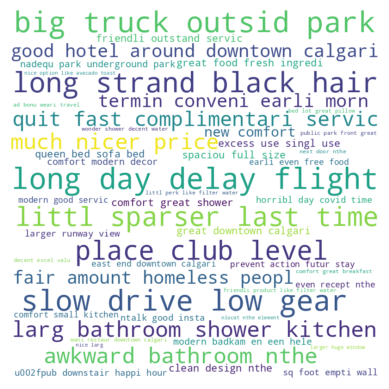

In [57]:
plotWordCloud(miScoredfKNP.set_index('Word')['MI Score'].to_dict(), **wordcloud_args)

Which noun phrases get the highest MI values? \\
"long day delay flight", "much nicer price", "fair amount homeless people", "awkward bathroom nthe" get the highest MI values. \\
Based on these results what would you recommend the hotels in your city might need to improve? \\
The city needs to shorten delay of flights. It also has a homelessness crisis it must deal with. Maybe it should consider chanigng bathroom arrangements to make it less awkward.


# Q4

## Q4a

In [58]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe

    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        print(word)
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)

    return pmiDf


def pmiCalc(df, word, gt_sentiment, label_column='groundTruth'):

    N = df.shape[0]

    px = sum(df[label_column]==gt_sentiment)
    py = sum(df[word]==True)
    pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])
    if px*py==0:
      return 0
    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)*N/(px*py))
    else:
        pmi = math.log(pxy*N/(px*py))
    return pmi

In [59]:
pmiposdf = pmiForAllCal(finaldfK,topk,'positive')
pmiposdf.sort_values('pmi',ascending=0).head(5)

100%|██████████| 50/50 [00:00<00:00, 343.18it/s]

great
clean
good
breakfast
would
calgary
nice
friendly
one
stayed
night
desk
front
service
well
comfortable
location
bed
time
also
restaurant
pool
u2019t
check
get
parking
nthe
place
airport
back
helpful
like
really
could
food
area
day
even
free
close
recommend
hot
excellent
next
beds
downtown
u2019s
floor
told
people


pmi
excellent    0.292934
comfortable  0.212809
great        0.210284
helpful      0.209082
downtown     0.194869

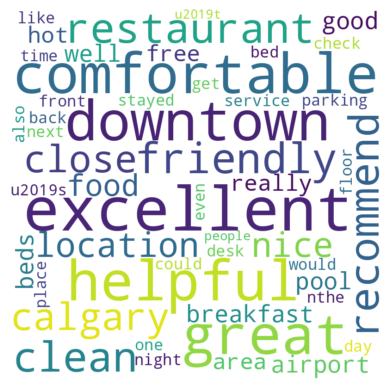

In [60]:
from sklearn.preprocessing import MinMaxScaler

def normalizeDict(myDict):
  scaler = MinMaxScaler()
  normalized_values = scaler.fit_transform([[v] for v in myDict.values()])
  normalized_dict = dict(zip(myDict.keys(), normalized_values.flatten()))
  return normalized_dict

plotWordCloud(normalizeDict(pmiposdf['pmi'].to_dict()), **wordcloud_args)

In [61]:
#Sorted top pmi words for negative reviews
pminegdf = pmiForAllCal(finaldfK,topk,'negative')
pminegdf.sort_values('pmi',ascending=0).head(5)

100%|██████████| 50/50 [00:00<00:00, 345.90it/s]

great
clean
good
breakfast
would
calgary
nice
friendly
one
stayed
night
desk
front
service
well
comfortable
location
bed
time
also
restaurant
pool
u2019t
check
get
parking
nthe
place
airport
back
helpful
like
really
could
food
area
day
even
free
close
recommend
hot
excellent
next
beds
downtown
u2019s
floor
told
people


pmi
told    1.115194
u2019t  0.649369
people  0.629022
could    0.50264
like      0.4663

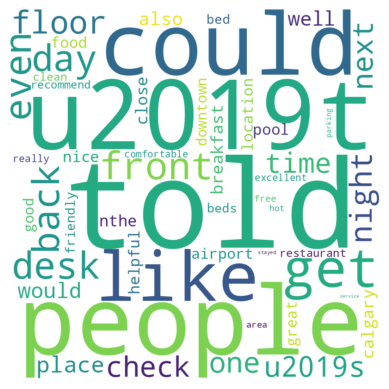

In [62]:
plotWordCloud(pminegdf['pmi'].to_dict(), **wordcloud_args)

 Discuss at least 3 interesting and/or locale-specific findings
about these top-ranked words.\\
1. poitive have adjectives mostly- things like clean, comfortable, great, etc
2. negatives have mostly nouns - front desk, people, night
3. for some reason, told is very indicative of negative sentiment... Maybe because someone would say smth like "I told the manager", ie it indicates a complaint.

## Q4b

In [63]:
pmiposdf = pmiForAllCal(finaldfKNP,topkNP,'positive')

100%|██████████| 50/50 [00:00<00:00, 391.20it/s]

new comfort
termin conveni earli morn
larger runway view
long strand black hair
littl sparser last time
place club level
comfort modern decor
friendli outstand servic
much nicer price
comfort great shower
nlocat nthe element
nice option like avacado toast
littl perk like filter water
comfort small kitchen
clean design nthe
spaciou full size
big truck outsid park
friendli product like filter water
wonder shower decent water
decent excel valu
mani restaur downtown calgari
public park front great
modern good servic
bed lot great pillow
next door nthe
larger huge window
ad bonu weari travel
fair amount homeless peopl
nice larg
good hotel around downtown calgari
comfort great breakfast
even recept nthe
earli even free food
east end downtown calgari
great downtown calgari
queen bed sofa bed
great food fresh ingredi
quit fast complimentari servic
awkward bathroom nthe
excess use singl use
nadequ park underground park
modern badkam en een hele
larg bathroom shower kitchen
u002fpub downstair ha

In [64]:
pmiposdf.sort_values('pmi',ascending=0).head(5)

pmi
new comfort           0.333645
queen bed sofa bed    0.333645
next door nthe        0.333645
ad bonu weari travel  0.333645
nice larg             0.333645

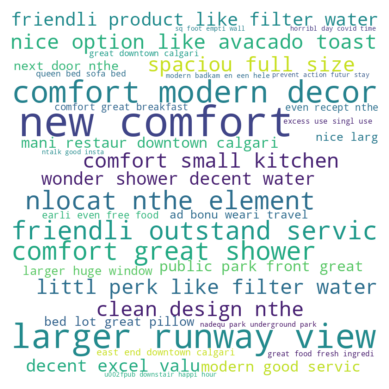

In [65]:
plotWordCloud(normalizeDict(pmiposdf['pmi'].to_dict()), **wordcloud_args)

In [66]:
#Sorted top pmi words for negative reviews
pminegdf = pmiForAllCal(finaldfKNP,topkNP,'negative')
pminegdf.sort_values('pmi',ascending=0).head(5)

100%|██████████| 50/50 [00:00<00:00, 369.19it/s]

new comfort
termin conveni earli morn
larger runway view
long strand black hair
littl sparser last time
place club level
comfort modern decor
friendli outstand servic
much nicer price
comfort great shower
nlocat nthe element
nice option like avacado toast
littl perk like filter water
comfort small kitchen
clean design nthe
spaciou full size
big truck outsid park
friendli product like filter water
wonder shower decent water
decent excel valu
mani restaur downtown calgari
public park front great
modern good servic
bed lot great pillow
next door nthe
larger huge window
ad bonu weari travel
fair amount homeless peopl
nice larg
good hotel around downtown calgari
comfort great breakfast
even recept nthe
earli even free food
east end downtown calgari
great downtown calgari
queen bed sofa bed
great food fresh ingredi
quit fast complimentari servic
awkward bathroom nthe
excess use singl use
nadequ park underground park
modern badkam en een hele
larg bathroom shower kitchen
u002fpub downstair ha

pmi
long day delay flight           1.259866
slow drive low gear             1.259866
termin conveni earli morn       1.259866
quit fast complimentari servic  1.259866
awkward bathroom nthe           1.259866

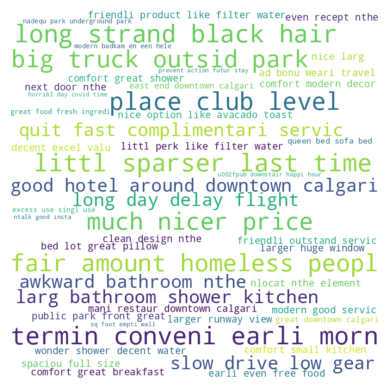

In [67]:
plotWordCloud(normalizeDict(pminegdf['pmi'].to_dict()), **wordcloud_args)

1. 'much nicer price' is apparently a negative sentiment. Perhaps they are comparing this restaurant to another restaurant, which has a much nicer price
2. 'horrible day covid time' is apparently positive. This may be becuase the guy is explainng how he is having a horrible day but the hotel helped?
3. These terms are generally longer than top K words, and are more unique to each set. As we saw before, intersection was empty set. This means these are more indicative of sentiment, without being too overused (ie none are stop phrases for hotels, which is good as it means they are all meaningful)

## Q4c

In [68]:
bestHoteldf = hotelDf[hotelDf['hotelName'] == 'Residence Inn by Marriott Calgary Downtown / Beltline District'].reset_index()
reviewsBest = bestHoteldf['reviewColumn'].values
reviewDFBest = evalSentences(reviewsBest, to_df=True, columns=['reviewCol','vader'])
topkBest = getTopKWords(reviewDFBest, 500)
bestHoteldfK = dataFrameTransformation(bestHoteldf, reviewDFBest, topkBest)

100%|██████████| 100/100 [00:00<00:00, 855.07it/s]

(100, 502)
(100, 11)


In [69]:
worstHoteldf = hotelDf[hotelDf['hotelName'] == 'Hyatt Place Calgary Airport'].reset_index()
reviewsWorst = worstHoteldf['reviewColumn'].values
reviewDFWorst = evalSentences(reviewsWorst, to_df=True, columns=['reviewCol','vader'])
topkWorst = getTopKWords(reviewDFWorst, 500)
worstHoteldfK = dataFrameTransformation(worstHoteldf, reviewDFWorst, topkWorst)

100%|██████████| 100/100 [00:00<00:00, 596.54it/s]


(100, 502)
(100, 11)


In [70]:
pmibestposdf = pmiForAllCal(bestHoteldfK,topkBest,'positive')

 10%|█         | 50/500 [00:00<00:00, 492.57it/s]

breakfast
great
calgary
well
clean
good
nice
stayed
one
would
residence
location
downtown
friendly
area
large
spacious
night
inn
view
parking
service
new
best
also
nthe
kitchen
buffet
modern
excellent
day
comfortable
suite
really
helpful
full
like
definitely
check
amazing
time
first
even
bed
city
u2019s
floor
beautiful
recommend
ever
desk
property
u2019t
food
bathroom
restaurants
dining
next
get
walk
free
front
options
better
everything
located
business
marriott
could
loved
lots
restaurant
amenities
walking
distance
views
equipped
every
fridge
coffee
size
huge
many
back
found
close
top
train
perfect
super
hot
price
nights
complimentary
around
away
big
lot
highly
bit
underground
quite
noise


 31%|███       | 155/500 [00:00<00:00, 502.44it/s]

stampede
always
two
got
brand
tower
place
shower
cold
mountain
lobby
housekeeping
wall
studio
water
think
hotels
due
open
plenty
etc
kitchenette
much
need
extended
visit
however
way
covid
enjoyed
experience
included
choice
issue
king
living
booked
minutes
ave
fruit
quiet
beds
quick
table
came
appointed
nearby
basic
family
come
days
inns
space
places
rate
see
sure
nbreakfast
especially
impressed
offered
variety
center
quality
safe
scrambled
right
u2019ve
eggs
offer
make
little
overall
morning
gym
selection
eat
staying
going
bar
easy
things
convenient
everyone
know
times
second
short
weekend
long
fresh
shopping
complete
district
suites
trip
high
fitness
available
continental
recommended
house
light


 51%|█████▏    | 257/500 [00:00<00:00, 494.19it/s]

choices
pretty
trains
kind
seating
though
travel
evening
microwave
building
already
windows
fantastic
usually
sofa
bars
far
wait
team
beltline
find
needed
welcoming
wonderful
thing
provided
hear
agent
nwe
lovely
made
look
still
loud
asked
last
attentive
facilities
nicely
wide
dinner
safeway
say
something
laid
different
extremely
guest
deal
upgraded
happy
fully
return
designed
egg
comfy
awesome
reception
nroom
probably
help
park
often
work
professional
use
areas
breakfasts
lounge
accommodating
waffle
person
machines
small
decent
sized
feel
meeting
nthis
looking
move
site
thought
stuff
extra
impressive
surprised
anything
spaces
guests
job
visiting
ask
several
couch
bring
reservation
sleep
issues
sheets
another
bother


 72%|███████▏  | 361/500 [00:00<00:00, 505.77it/s]

line
busy
3rd
tip
forward
comes
young
without
indigo
fairly
core
since
paid
stays
shops
bedroom
10th
blocks
8th
main
lucky
choose
stop
warm
offers
nicest
experienced
quickly
sound
bottles
treat
value
money
customer
strong
wish
start
nrooms
package
almost
aspect
expected
lady
info
screen
facing
functional
station
option
wanted
cars
problem
checking
outstanding
bacon
sausage
mountains
asking
u2019d
crowded
dishwasher
plates
longer
outside
offerings
eating
part
shop
shampoo
wash
called
seems
cleaned
polite
try
2019
anywhere
door
kids
addition
nwhen
name
waffles
cheap
drive
design
doors
couple
anyone
love
provide
pool
visited
within
stains
makes
tea
put
appeared
minor
done


100%|██████████| 500/500 [00:00<00:00, 503.76it/s]

pay
separate
served
pleasantly
seen
properties
sam
manager
keshavi
valet
situated
week
thanks
box
u2019ll
daily
liked
nothing
phone
delicious
access
mattress
nlocation
change
want
smooth
party
directly
side
frequently
rating
largest
wife
rise
entering
able
take
masks
device
hdmi
helped
cafe
u201d
terrible
never
arrival
note
garage
nstaff
sitting
three
cable
online
guys
ud83d
checked
closed
entertainment
canada
supermarket
town
bell
special
lighting
internet
gold
member
receive
gorgeous
dressing
mid
somewhere
bright
felt
notch
truly
floors
furnished
nnice
nall
minute
stephen
tourist
attractions
security
hash
white
cereals
course
wine
posted


In [71]:
pmibestposdf.sort_values('pmi',ascending=0).head(5)

pmi
laid    0.072571
3rd     0.072571
main    0.072571
8th     0.072571
blocks  0.072571

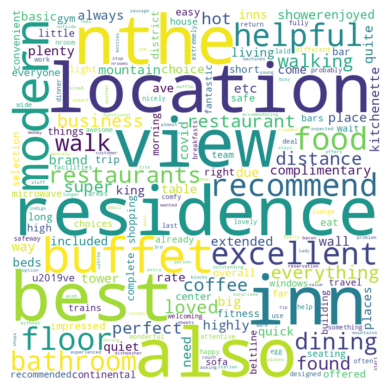

In [72]:
plotWordCloud(pmibestposdf['pmi'].to_dict(), **wordcloud_args)

The best hotel is good because of its location, buffet option, it is modern in design, staff is helpful, view is good, bathroom is clean, and food is liked by residents.

In [73]:
#Sorted top pmi words for negative reviews
pmibestnegdf = pmiForAllCal(bestHoteldfK,topkBest,'negative')
pmibestnegdf.sort_values('pmi',ascending=0).head(5)

 15%|█▌        | 75/500 [00:00<00:00, 743.62it/s]

breakfast
great
calgary
well
clean
good
nice
stayed
one
would
residence
location
downtown
friendly
area
large
spacious
night
inn
view
parking
service
new
best
also
nthe
kitchen
buffet
modern
excellent
day
comfortable
suite
really
helpful
full
like
definitely
check
amazing
time
first
even
bed
city
u2019s
floor
beautiful
recommend
ever
desk
property
u2019t
food
bathroom
restaurants
dining
next
get
walk
free
front
options
better
everything
located
business
marriott
could
loved
lots
restaurant
amenities
walking
distance
views
equipped
every
fridge
coffee
size
huge
many
back
found
close
top
train
perfect
super
hot
price
nights
complimentary
around
away
big
lot
highly
bit
underground
quite
noise
stampede
always
two
got
brand
tower
place
shower
cold
mountain
lobby
housekeeping
wall
studio
water
think
hotels
due
open
plenty
etc
kitchenette
much
need
extended
visit
however
way
covid
enjoyed
experience
included
choice
issue
king
living
booked
minutes
ave
fruit
quiet
beds
quick
table
came
appoint

 49%|████▉     | 246/500 [00:00<00:00, 774.44it/s]

places
rate
see
sure
nbreakfast
especially
impressed
offered
variety
center
quality
safe
scrambled
right
u2019ve
eggs
offer
make
little
overall
morning
gym
selection
eat
staying
going
bar
easy
things
convenient
everyone
know
times
second
short
weekend
long
fresh
shopping
complete
district
suites
trip
high
fitness
available
continental
recommended
house
light
choices
pretty
trains
kind
seating
though
travel
evening
microwave
building
already
windows
fantastic
usually
sofa
bars
far
wait
team
beltline
find
needed
welcoming
wonderful
thing
provided
hear
agent
nwe
lovely
made
look
still
loud
asked
last
attentive
facilities
nicely
wide
dinner
safeway
say
something
laid
different
extremely
guest
deal
upgraded
happy
fully
return
designed
egg
comfy
awesome
reception
nroom
probably
help
park
often
work
professional
use
areas
breakfasts
lounge
accommodating
waffle
person
machines
small
decent
sized
feel
meeting
nthis
looking
move
site
thought
stuff
extra
impressive
surprised
anything


 80%|████████  | 400/500 [00:00<00:00, 724.90it/s]

spaces
guests
job
visiting
ask
several
couch
bring
reservation
sleep
issues
sheets
another
bother
line
busy
3rd
tip
forward
comes
young
without
indigo
fairly
core
since
paid
stays
shops
bedroom
10th
blocks
8th
main
lucky
choose
stop
warm
offers
nicest
experienced
quickly
sound
bottles
treat
value
money
customer
strong
wish
start
nrooms
package
almost
aspect
expected
lady
info
screen
facing
functional
station
option
wanted
cars
problem
checking
outstanding
bacon
sausage
mountains
asking
u2019d
crowded
dishwasher
plates
longer
outside
offerings
eating
part
shop
shampoo
wash
called
seems
cleaned
polite
try
2019
anywhere
door
kids
addition
nwhen
name
waffles
cheap
drive
design
doors
couple
anyone
love
provide
pool
visited
within
stains
makes
tea
put
appeared
minor
done
pay
separate
served
pleasantly
seen
properties
sam
manager
keshavi
valet
situated
week
thanks
box
u2019ll
daily
liked
nothing
phone
delicious
access
mattress
nlocation
change
want
smooth
party
directly
side
frequently
rating

100%|██████████| 500/500 [00:00<00:00, 706.92it/s]

canada
supermarket
town
bell
special
lighting
internet
gold
member
receive
gorgeous
dressing
mid
somewhere
bright
felt
notch
truly
floors
furnished
nnice
nall
minute
stephen
tourist
attractions
security
hash
white
cereals
course
wine
posted


pmi
terrible   2.65926
guys       2.65926
online     2.65926
garage     2.65926
nwe       2.371578

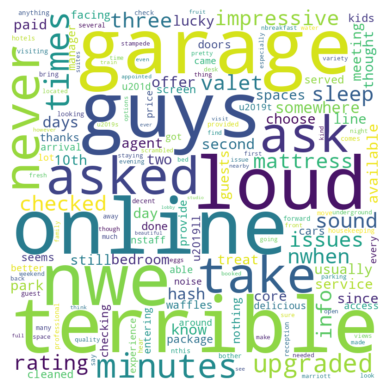

In [74]:
plotWordCloud(pmibestnegdf['pmi'].to_dict(), **wordcloud_args)

Some bad things about the best hotel is that it is loud. There seems to be some problems as well with the garage.

In [75]:
#Sorted top pmi words for negative reviews
pmiworstposdf = pmiForAllCal(worstHoteldfK,topkWorst,'positive')
pmiworstposdf.sort_values('pmi',ascending=0).head(5)

 32%|███▏      | 158/500 [00:00<00:00, 770.12it/s]

shuttle
airport
breakfast
service
hyatt
would
clean
great
good
one
calgary
night
desk
time
place
front
told
minutes
comfortable
get
nice
day
water
check
food
like
friendly
u2019t
shower
stayed
never
hour
hot
could
flight
back
location
experience
free
arrived
left
driver
needed
call
another
next
bar
though
bed
recommend
reservation
even
asked
new
price
quiet
every
really
also
table
booked
found
said
called
close
helpful
coffee
always
u2019s
restaurant
excellent
bad
beds
cold
available
late
pick
taxi
well
times
area
many
little
away
large
made
easy
waited
manager
come
much
uber
options
modern
however
rude
hotels
staying
best
items
parking
included
around
hours
hourly
people
morning
rate
short
needs
guests
convenient
took
whole
nthe
nbreakfast
enough
make
find
extra
work
spacious
big
minute
employees
thank
help
first
checked
wait
absolutely
drive
need
person
customer
amount
online
better
charged
family
due
loud
return
min
provided
use
bus
may
days
selection
full
eggs
cereal
towels
floor
l

 61%|██████    | 306/500 [00:00<00:00, 676.20it/s]

charge
menu
requested
bathroom
buffet
able
simple
door
overall
going
waiting
everything
felt
issue
tried
arrive
ask
take
pay
later
visit
nothing
property
nelson
disappointed
coming
u2026
trying
early
got
plus
potatoes
basic
value
right
nwe
reception
extremely
toast
fruit
pillows
pool
u2019ve
far
used
ever
ngreat
access
highly
questions
long
travelling
sure
missed
runs
sleep
lack
instead
two
amenities
things
came
order
eat
delayed
system
customers
leave
job
someone
freezing
paper
went
arriving
expected
run
worst
ended
pleasant
definitely
phone
tell
member
else
given
last
arrival
perfect
middle
travel
prompt
ride
horrible
inside
dirty
kept
nit
quality
busy
limited
pressure
members
furthermore
past
consistent
often
demand
sausage
bagels
bath
none
housekeeping
actually
space
downtown
fee
appreciated
offered
feel
nthis
maintenance
efficient
nights
size
managed
five
temperature
variety
care
spot
since
knew
unhelpful
think
different
fries
totally
listed
know
girl
weather
1am
treated
standing


100%|██████████| 500/500 [00:00<00:00, 696.73it/s]

thing
laid
enjoyed
casino
complimentary
others
managers
connect
u2019m
olivia
evidence
bedbugs
fine
sick
sausages
wheat
cereals
dishes
cups
unfortunately
avoid
second
understand
u201d
okay
unfortunate
brand
cab
clearly
priced
banff
surprisingly
happily
clear
kettle
machine
watch
happen
deal
let
welcomed
pre
covid
fast
nif
staffing
seemed
keep
cutlery
nin
appearance
lots
looks
touch
carpet
believe
reviews
regency
broken
charges
credit
card
contact
numerous
difference
street
huge
super
100
crazy
deposit
sterile
white
air
several
opened
nnice
linens
fixed
server
complaint
highway
prior
flying
professional
king
sofa
small
ncheck
journey
nwould
walk
dinner
exceptional
accommodating
near
awesome
westjet
connecting
layover
option
open
putting
list
required
unable
explore
cannot
voucher
nrestaurant
u002fbar
burnt
reserved
2am
appeared
caused
evening
clerk
nto
midnight
outside
negative
finally
horrendous
international
poorly
conference
refused
three
175
nightly
web
mentioned
ordered
buy
thought

pmi
value       0.634878
expected    0.634878
buffet      0.634878
connecting  0.634878
awesome     0.634878

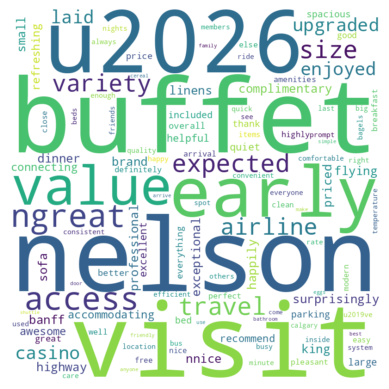

In [76]:
plotWordCloud(pmiworstposdf['pmi'].to_dict(), **wordcloud_args)

One good thing about the worst hotel is the buffet. There seems to be not much else that is good.

In [77]:
#Sorted top pmi words for negative reviews
pmiworstnegdf = pmiForAllCal(worstHoteldfK,topkWorst,'negative')
pmiworstnegdf.sort_values('pmi',ascending=0).head(5)

 33%|███▎      | 164/500 [00:00<00:00, 791.75it/s]

shuttle
airport
breakfast
service
hyatt
would
clean
great
good
one
calgary
night
desk
time
place
front
told
minutes
comfortable
get
nice
day
water
check
food
like
friendly
u2019t
shower
stayed
never
hour
hot
could
flight
back
location
experience
free
arrived
left
driver
needed
call
another
next
bar
though
bed
recommend
reservation
even
asked
new
price
quiet
every
really
also
table
booked
found
said
called
close
helpful
coffee
always
u2019s
restaurant
excellent
bad
beds
cold
available
late
pick
taxi
well
times
area
many
little
away
large
made
easy
waited
manager
come
much
uber
options
modern
however
rude
hotels
staying
best
items
parking
included
around
hours
hourly
people
morning
rate
short
needs
guests
convenient
took
whole
nthe
nbreakfast
enough
make
find
extra
work
spacious
big
minute
employees
thank
help
first
checked
wait
absolutely
drive
need
person
customer
amount
online
better
charged
family
due
loud
return
min
provided
use
bus
may
days
selection
full
eggs
cereal
towels
floor
l

 64%|██████▍   | 321/500 [00:00<00:00, 724.80it/s]

simple
door
overall
going
waiting
everything
felt
issue
tried
arrive
ask
take
pay
later
visit
nothing
property
nelson
disappointed
coming
u2026
trying
early
got
plus
potatoes
basic
value
right
nwe
reception
extremely
toast
fruit
pillows
pool
u2019ve
far
used
ever
ngreat
access
highly
questions
long
travelling
sure
missed
runs
sleep
lack
instead
two
amenities
things
came
order
eat
delayed
system
customers
leave
job
someone
freezing
paper
went
arriving
expected
run
worst
ended
pleasant
definitely
phone
tell
member
else
given
last
arrival
perfect
middle
travel
prompt
ride
horrible
inside
dirty
kept
nit
quality
busy
limited
pressure
members
furthermore
past
consistent
often
demand
sausage
bagels
bath
none
housekeeping
actually
space
downtown
fee
appreciated
offered
feel
nthis
maintenance
efficient
nights
size
managed
five
temperature
variety
care
spot
since
knew
unhelpful
think
different
fries
totally
listed
know
girl
weather
1am
treated
standing
almost
damage
week
looked
poor
hope
see
eve

100%|██████████| 500/500 [00:00<00:00, 718.17it/s]

half
point
safe
happy
choices
advised
situation
kids
want
book
request
asian
hair
highlights
friends
wanted
thing
laid
enjoyed
casino
complimentary
others
managers
connect
u2019m
olivia
evidence
bedbugs
fine
sick
sausages
wheat
cereals
dishes
cups
unfortunately
avoid
second
understand
u201d
okay
unfortunate
brand
cab
clearly
priced
banff
surprisingly
happily
clear
kettle
machine
watch
happen
deal
let
welcomed
pre
covid
fast
nif
staffing
seemed
keep
cutlery
nin
appearance
lots
looks
touch
carpet
believe
reviews
regency
broken
charges
credit
card
contact
numerous
difference
street
huge
super
100
crazy
deposit
sterile
white
air
several
opened
nnice
linens
fixed
server
complaint
highway
prior
flying
professional
king
sofa
small
ncheck
journey
nwould
walk
dinner
exceptional
accommodating
near
awesome
westjet
connecting
layover
option
open
putting
list
required
unable
explore
cannot
voucher
nrestaurant
u002fbar
burnt
reserved
2am
appeared
caused
evening
clerk
nto
midnight
outside
negative
fi

pmi
horrible  0.755023
outside   0.755023
deposit   0.755023
crazy     0.755023
100       0.755023

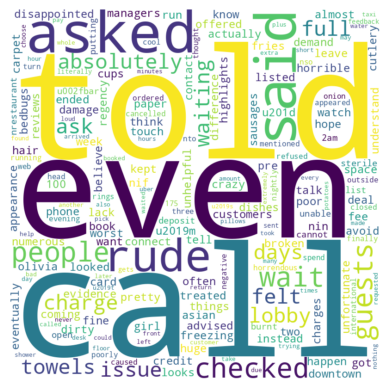

In [78]:
plotWordCloud(pmiworstnegdf['pmi'].to_dict(), **wordcloud_args)

What makes worst hotel so bad? Damage to the building, rude staff, long wait, dirty area.

In [79]:
bestHoteldf = hotelDf[hotelDf['hotelName'] == 'Residence Inn by Marriott Calgary Downtown / Beltline District'].reset_index()
reviewsBest = bestHoteldf['reviewColumn'].values
reviewDFBest = evalSentences(reviewsBest, to_df=True, columns=['reviewCol','vader'])
topkNPBest = getTopKNP(reviewDFBest, 50, revised_chunker)
bestHoteldfKNP = NPdataFrameTransformation(bestHoteldf, reviewDFBest, topkNPBest, revised_chunker)
print(bestHoteldfKNP.shape)

worstHoteldf = hotelDf[hotelDf['hotelName'] == 'Hyatt Place Calgary Airport'].reset_index()
reviewsWorst = worstHoteldf['reviewColumn'].values
reviewDFWorst = evalSentences(reviewsWorst, to_df=True, columns=['reviewCol','vader'])
topkNPWorst = getTopKNP(reviewDFWorst, 50, revised_chunker)
print(len(topkNPWorst))
worstHoteldfKNP = NPdataFrameTransformation(worstHoteldf, reviewDFWorst, topkNPWorst, revised_chunker)
print(worstHoteldfKNP.shape)

100%|██████████| 100/100 [00:00<00:00, 179.58it/s]


(100, 17)


100%|██████████| 100/100 [00:00<00:00, 656.57it/s]


8
(100, 13)


In [80]:
pmibestposdfKNP = pmiForAllCal(bestHoteldfKNP,topkNPBest,'positive')

100%|██████████| 12/12 [00:00<00:00, 324.82it/s]

comfort bed nthe breakfast
comfort friendli servic
level resid
spaciou full kitchen
modern properti good citi
good job perfum allergi
downtown calgari sure front
nlot good nearbi
websit name multipl page
huge beauti great view
cheaper price free park
excel downtown calgari


In [81]:
pmibestposdfKNP.sort_values('pmi',ascending=0).head(5)

pmi
comfort bed nthe breakfast  0.072571
comfort friendli servic     0.072571
level resid                 0.072571
modern properti good citi   0.072571
good job perfum allergi     0.072571

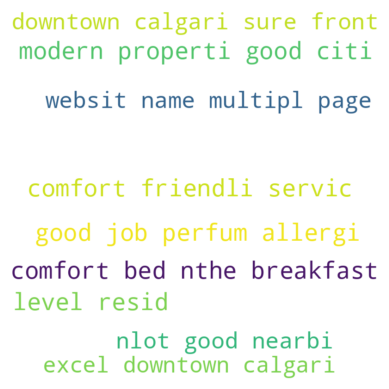

In [82]:
plotWordCloud(normalizeDict(pmibestposdfKNP['pmi'].to_dict()), **wordcloud_args)

best hotel is good because of cheaper price, free parking, comfrotable beds, friendly service, modern property, good city

In [83]:
pmibestnegdfKNP = pmiForAllCal(bestHoteldfKNP,topkNPBest,'negative')
pmibestnegdfKNP.sort_values('pmi',ascending=0).head(5)

100%|██████████| 12/12 [00:00<00:00, 521.16it/s]

comfort bed nthe breakfast
comfort friendli servic
level resid
spaciou full kitchen
modern properti good citi
good job perfum allergi
downtown calgari sure front
nlot good nearbi
websit name multipl page
huge beauti great view
cheaper price free park
excel downtown calgari


pmi
spaciou full kitchen        2.65926
huge beauti great view      2.65926
cheaper price free park     2.65926
comfort bed nthe breakfast -6.55108
comfort friendli servic    -6.55108

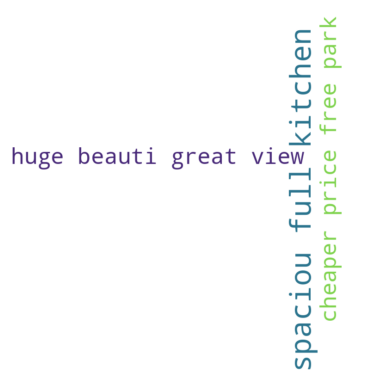

In [84]:
plotWordCloud(normalizeDict(pmibestnegdfKNP['pmi'].to_dict()), **wordcloud_args)

even the negative reviews for this hotel have positive words. Theres nothing explicitly negative here

In [85]:
#Sorted top pmi words for negative reviews
pmiworstposdfKNP = pmiForAllCal(worstHoteldfKNP,topkNPWorst,'positive')
pmiworstposdfKNP.sort_values('pmi',ascending=0).head(5)

100%|██████████| 8/8 [00:00<00:00, 649.83it/s]

spaciou good wifi
larg tv multipl channel
limit select dirti cutleri
ladi red hair
free shuttl complimentari breakfast
bacon select chees croissant
great modern touch
excel servic help


pmi
spaciou good wifi                    0.634878
larg tv multipl channel              0.634878
free shuttl complimentari breakfast  0.634878
bacon select chees croissant         0.634878
great modern touch                   0.634878

In [86]:
pmiworstposdfKNP['pmi'].to_dict()

{'spaciou good wifi': 0.6348782724359695,
 'larg tv multipl channel': 0.6348782724359695,
 'limit select dirti cutleri': -8.575462099540212,
 'ladi red hair': -8.575462099540212,
 'free shuttl complimentari breakfast': 0.6348782724359695,
 'bacon select chees croissant': 0.6348782724359695,
 'great modern touch': 0.6348782724359695,
 'excel servic help': 0.6348782724359695}

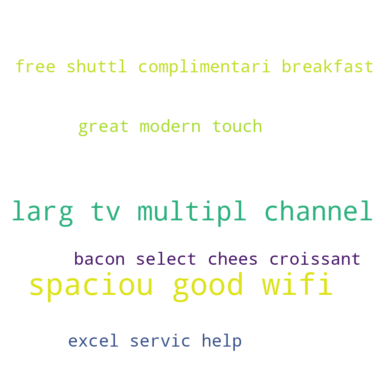

In [87]:
plotWordCloud(normalizeDict(pmiworstposdfKNP['pmi'].to_dict()), **wordcloud_args)

As you can see, the worst hotel has barely anything positve about it. There is still some good stuff, but only a few reviews clearly have any positive sentiment

In [88]:
#Sorted top pmi words for negative reviews
pmiworstnegdfKNP = pmiForAllCal(worstHoteldfKNP,topkNPWorst,'negative')
pmiworstnegdfKNP.sort_values('pmi',ascending=0).head(5)

100%|██████████| 8/8 [00:00<00:00, 666.90it/s]

spaciou good wifi
larg tv multipl channel
limit select dirti cutleri
ladi red hair
free shuttl complimentari breakfast
bacon select chees croissant
great modern touch
excel servic help


pmi
limit select dirti cutleri           0.755023
ladi red hair                        0.755023
spaciou good wifi                   -8.455318
larg tv multipl channel             -8.455318
free shuttl complimentari breakfast -8.455318

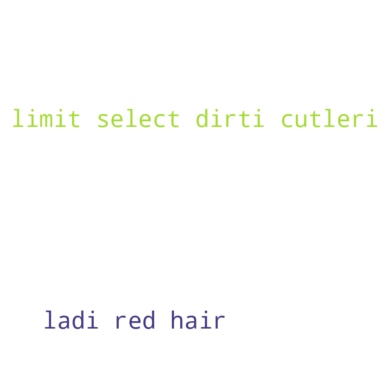

In [89]:
plotWordCloud(normalizeDict(pmiworstnegdfKNP['pmi'].to_dict()), **wordcloud_args)

We see words like limited selection, dirty, complaints about cutlery, etc.

# Q5

**Note** Remember to save a static image of the map in the notebook

## Q5a

In [90]:
def getHistogram(df, measure, title,figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)

    if measure=='both':
        x = [df['ratingScore'].values/5]
        y = [df['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.hist(x, bins, label='normalized Ground Truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        plt.hist(df[measure].values)

    plt.xlabel("Value")
    plt.ylabel("Frequency")

## (i)

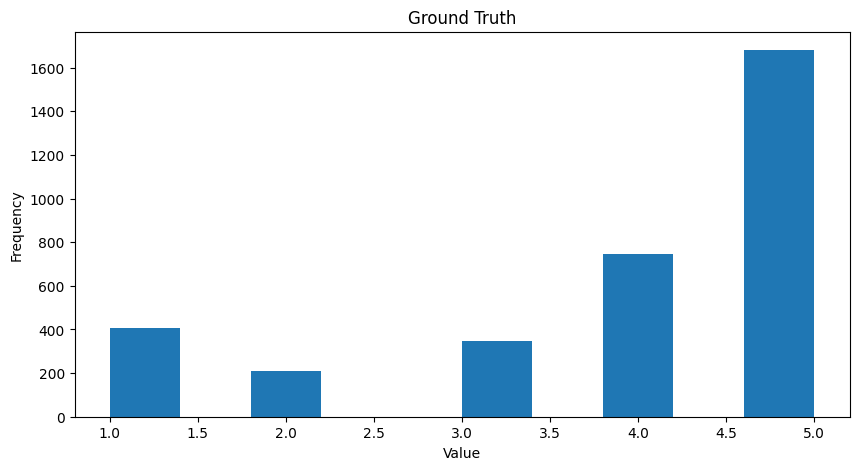

In [91]:
#what is the distrubution in ground truth scores like?
getHistogram(finaldf,'ratingScore', 'Ground Truth')

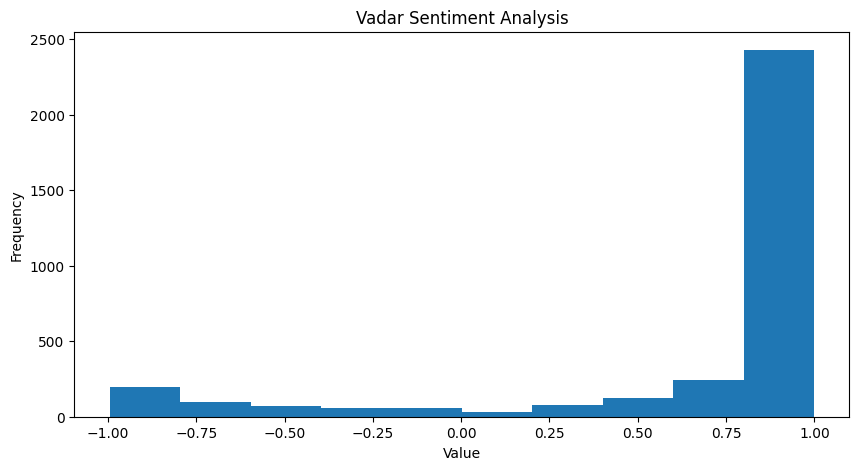

In [92]:
# what is the distrubtuion in vader scores like?
getHistogram(finaldf, 'vader', 'Vadar Sentiment Analysis')

Vader is more skewed than avg_rating. This is because computer algorithms will jump to more binary/extreme conclusions from certain words, whereas humans when writing reviews can express themselves in various different ways. The sentiment analyzer assumes each word means the same thing for every person (ie great is same for everyone.) This is shown as frequency of 1 and 0 are relatively high for vader bu tin between, they dont occur as much. Indeed, a human with rating 4 will liekly write  a review that vader will rate 1.

## (ii)

Text(0, 0.5, 'Hotel Count')

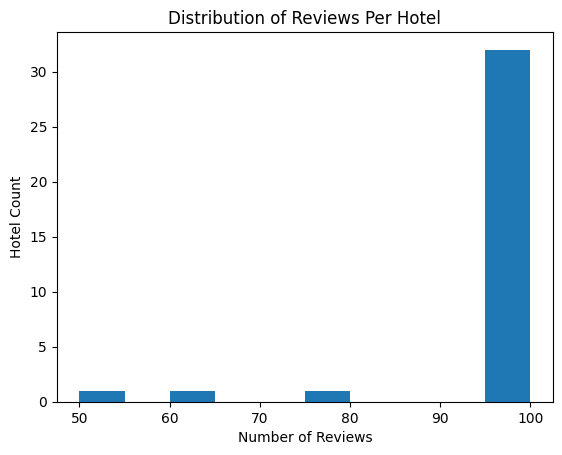

In [93]:
plt.hist(finaldf['hotelName'].value_counts())
plt.title("Distribution of Reviews Per Hotel")
plt.xlabel("Number of Reviews")
plt.ylabel("Hotel Count")

Well I capped the number of reviews per hotel at 100. SO, this graph shows most hotels get >100 reviews.

## (iii)

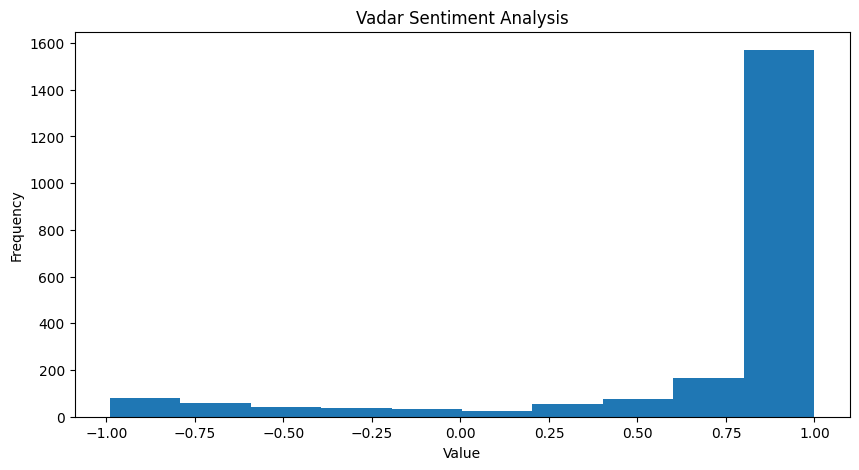

In [94]:
# what is the distrubtuion in vader scores like?
top5 = ['Residence Inn by Marriott Calgary Downtown / Beltline District', 'Delta Hotels by Marriott Calgary Downtown', 'Wicked Hostels - Calgary', 'Holiday Inn &amp; Suites Calgary South - Conference Ctr, an IHG Hotel', 'The Westin Calgary', 'Le Germain Hotel Calgary', 'Sandman Signature Calgary Airport Hotel', 'Delta Hotels by Marriott Calgary South']
bottom5 = ['Canadas Best Value Inn Calgary Chinook Station', 'Holiday Inn Express &amp; Suites Calgary South-Macleod Trail S, an IHG Hotel', 'Hyatt Place Calgary Airport', 'Econo Lodge Motel Village', 'Econo Lodge Inn &amp; Suites University']
getHistogram(finaldf[~finaldf['hotelName'].isin(top5+bottom5)], 'vader', 'Vadar Sentiment Analysis')

## Q5b

## (i)

In [95]:
avg_df.columns

Index(['avg_vader', 'median_vader', 'avg_ratingScore', 'total_reviews'], dtype='object')

In [96]:
# how do the ratings compare for 5 hotels?
five_hotels = avg_df.nlargest(5, 'avg_ratingScore')
five_hotels = five_hotels.index.values

hotel_list_ratings = []
for hotel in five_hotels:
  _hotel = finaldf.loc[finaldf['hotelName'] == hotel]['ratingScore']
  hotel_list_ratings.append(_hotel)

hotel_list_vader = []
for hotel in five_hotels:
  _hotel = finaldf.loc[finaldf['hotelName'] == hotel]['vader']
  hotel_list_vader.append(_hotel)

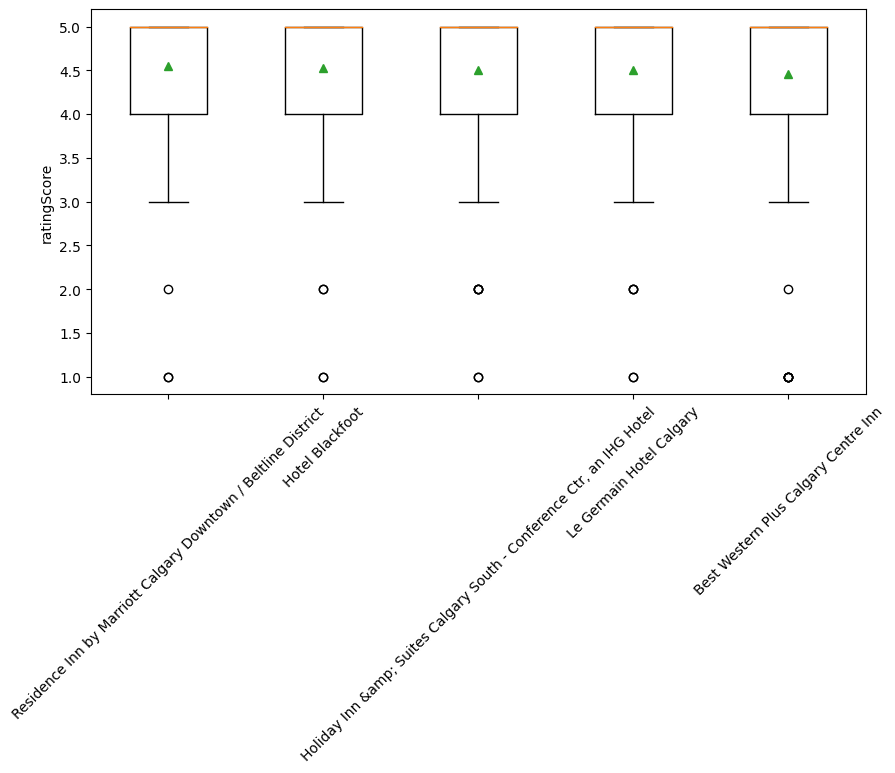

In [97]:
# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list_ratings, showmeans=True)
plt.xticks(np.arange(1,6), five_hotels,rotation=45)
plt.ylabel('ratingScore')
plt.show()

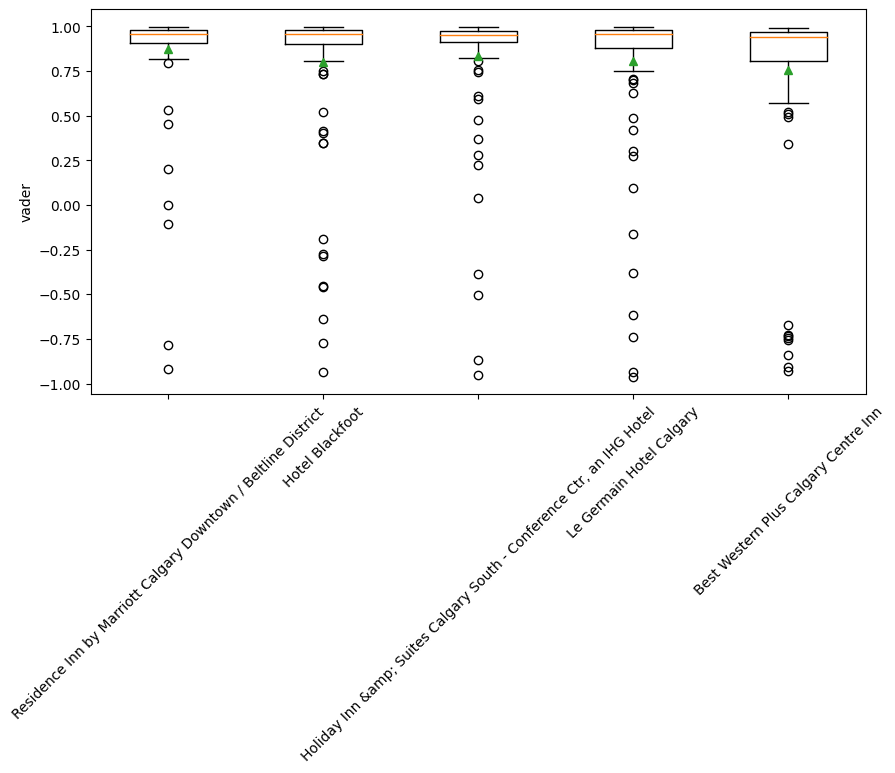

In [98]:
# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list_vader, showmeans=True)
plt.xticks(np.arange(1,6), five_hotels,rotation=45)
plt.ylabel('vader')
plt.show()

## (ii)

In [99]:
five_hotels = avg_df.nlargest(5, 'avg_ratingScore').index.values
temp = finaldf[finaldf['hotelName'].isin(five_hotels)]
temp.groupby('hotelName').mean()

<ipython-input-99-4f599f4be089>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp.groupby('hotelName').mean()


ratingScore     vader
hotelName                                                                                   
Best Western Plus Calgary Centre Inn                                          4.46  0.755501
Holiday Inn &amp; Suites Calgary South - Conference Ctr, an IHG Hotel         4.50  0.836648
Hotel Blackfoot                                                               4.53  0.799834
Le Germain Hotel Calgary                                                      4.50  0.807140
Residence Inn by Marriott Calgary Downtown / Beltline District                4.55  0.875744

In [100]:
finaldf.groupby('hotelName').var()

<ipython-input-100-0259def3f420>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  finaldf.groupby('hotelName').var()


ratingScore     vader
hotelName                                                                                          
Acclaim Hotel Calgary Airport                                                    1.791818  0.266169
Alt Hotel Calgary East Village                                                   0.591934  0.144404
Amenida Residences                                                               1.343838  0.289764
Best Western Plus Calgary Centre Inn                                             1.139798  0.225840
Best Western Plus Port O&#39;Call Hotel                                          2.262626  0.353339
Best Western Plus Suites Downtown                                                1.967273  0.220777
Best Western Plus Village Park Inn                                               1.446061  0.179972
Best Western Premier Calgary Plaza Hotel &amp; Conference Centre                 1.245556  0.175010
Calgary Airport Marriott In-Terminal Hotel                                       1.032222  0.148733
Canadas Best Value Inn Calgary Chinook Station                                   1.512727  0.593014
Carriage House Hotel &amp; Conference Centre                                     1.010101  0.189657
Centro Motel                                                                     2.010101  0.319368
Delta Hotels by Marriott Calgary Downtown                                        0.710707  0.142926
Delta Hotels by Marriott Calgary South                                           1.448081  0.308592
Econo Lodge Inn &amp; Suites University                                          2.005657  0.493734
Econo Lodge Motel Village                                                        1.536465  0.531004
Element Calgary Airport                                                          1.858182  0.379778
Executive Residency by Best Western Calgary City View North                      2.372828  0.292954
Four Points by Sheraton Calgary Airport                                          1.847576  0.342730
Hilton Garden Inn Calgary Downtown                                               1.824141  0.332312
Holiday Inn &amp; Suites Calgary Airport North                                   1.682540  0.240638
Holiday Inn &amp; Suites Calgary South - Conference Ctr, an IHG Hotel            0.858586  0.125124
Holiday Inn Calgary-Airport, an IHG Hotel                                        2.271818  0.366057
Holiday Inn Express &amp; Suites Calgary South-Macleod Trail S, an IHG Hotel     3.063737  0.585069
Homewood Suites by Hilton Calgary Downtown                                       1.681919  0.395669
Hotel Blackfoot                                                                  0.675859  0.170645
Hyatt Place Calgary Airport                                                      2.717172  0.507767
Le Germain Hotel Calgary                                                         0.838384  0.163266
Residence Inn by Marriott Calgary Downtown / Beltline District                   0.633838  0.092480
Sandman Signature Calgary Airport Hotel                                          1.369796  0.121694
Sandman Signature Calgary Downtown Hotel                                         1.464545  0.309393
SureStay Plus By Best Western Calgary South East                                 1.549899  0.133365
The Westin Calgary                                                               1.513030  0.110809
The Westin Calgary Airport                                                       1.300606  0.153581
Wicked Hostels - Calgary                                                         1.565657  0.127401

## (iii)

For a quick analysis, mean and variance are good enough. For more detailed analysis, the box plot gives more informative results, showing the mean but also the quartiles and outliers.

## Q5c

## (i)

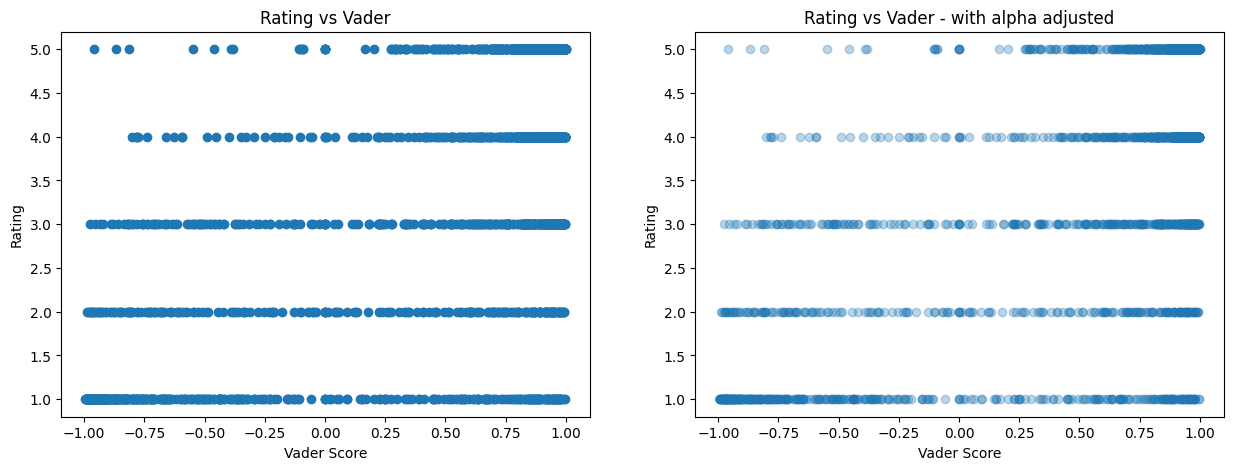

In [101]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
rating_scores = finaldf['ratingScore'].values
vader_scores = finaldf['vader'].values
ax[0].plot(vader_scores, rating_scores,"o")
ax[1].plot(vader_scores, rating_scores,"o", alpha=0.3)

ax[0].set_title('Rating vs Vader')
ax[1].set_title('Rating vs Vader - with alpha adjusted')

for _ax in ax:
  _ax.set_ylabel('Rating')
  _ax.set_xlabel('Vader Score')

Vader only really agrees strongly with rating if rating is high (4,5)

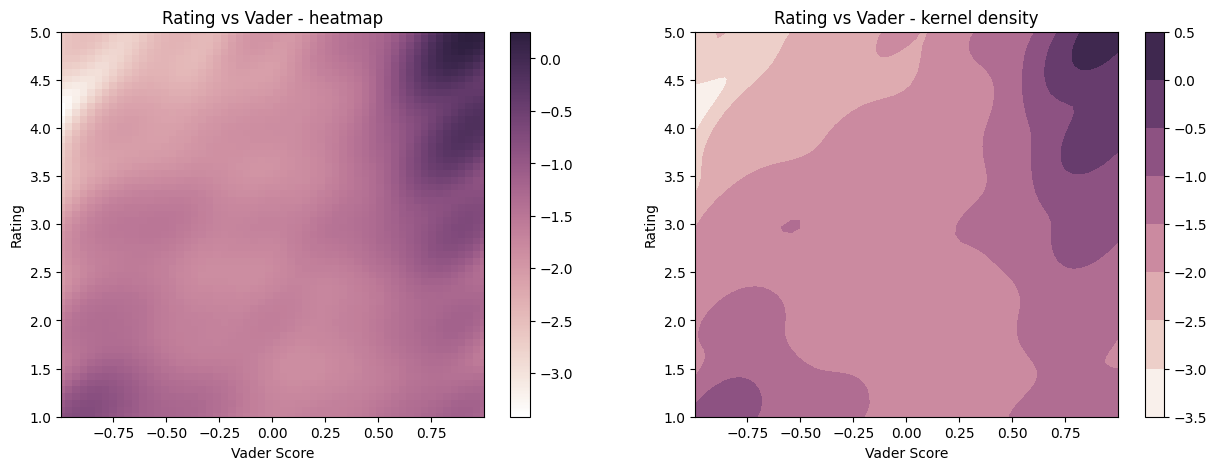

In [102]:
k = gaussian_kde(np.vstack([vader_scores, rating_scores]))
xi, yi = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

b1 = ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
b2 = ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(vader_scores.min(), vader_scores.max())
ax1.set_ylim(rating_scores.min(), rating_scores.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(rating_scores.min(), rating_scores.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Rating vs Vader - heatmap')
ax2.set_title('Rating vs Vader - kernel density');

This agrees with previous claim, as top right is darkest region. The bottom left to top right diagonal is strongest in color, this is expected as this is region of agreement, and it grows as we go closer to top right.

## (ii)

Text(0, 0.5, 'Review Length')

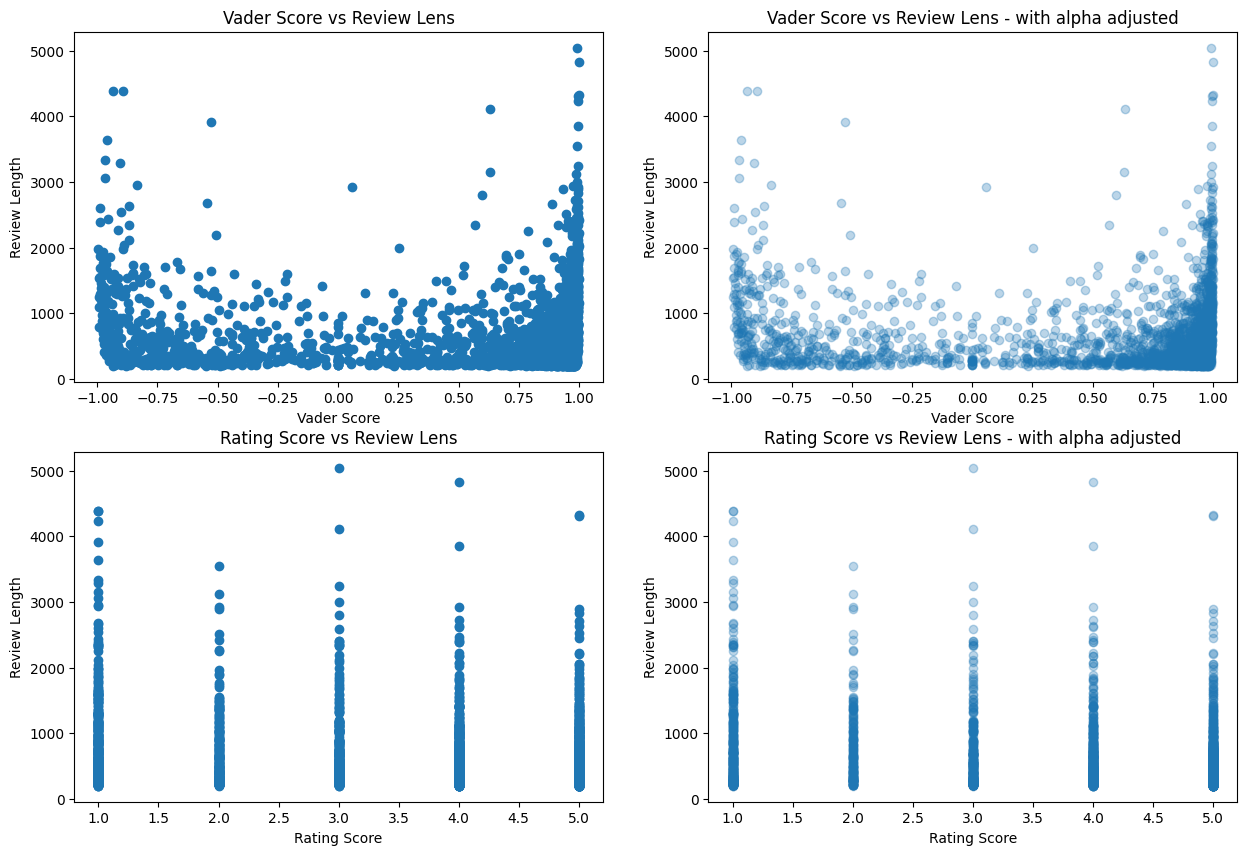

In [103]:
from regex.regex import E
fig, ax = plt.subplots(2,2,figsize=(15,10),sharex=False,sharey=False)
rating_scores = finaldf['ratingScore'].values
vader_scores = finaldf['vader'].values
review_lens = finaldf['reviewCol'].apply(len).tolist()

ax[0,0].plot(vader_scores, review_lens,"o")
ax[0,1].plot(vader_scores, review_lens,"o", alpha=0.3)
ax[1,0].plot(rating_scores, review_lens,"o")
ax[1,1].plot(rating_scores, review_lens,"o", alpha=0.3)

ax[0,0].set_title('Vader Score vs Review Lens')
ax[0,0].set_xlabel('Vader Score')
ax[0,0].set_ylabel('Review Length')

ax[0,1].set_title('Vader Score vs Review Lens - with alpha adjusted')
ax[0,1].set_xlabel('Vader Score')
ax[0,1].set_ylabel('Review Length')

ax[1,0].set_title('Rating Score vs Review Lens')
ax[1,0].set_xlabel('Rating Score')
ax[1,0].set_ylabel('Review Length')

ax[1,1].set_title('Rating Score vs Review Lens - with alpha adjusted')
ax[1,1].set_xlabel('Rating Score')
ax[1,1].set_ylabel('Review Length')

Overall review lengths are more often short than long. However, longer reviews clearly indicate either a more positive or more negative review. This is expected as more emotional statements will likely be longer and go in detail about the person's experiences.

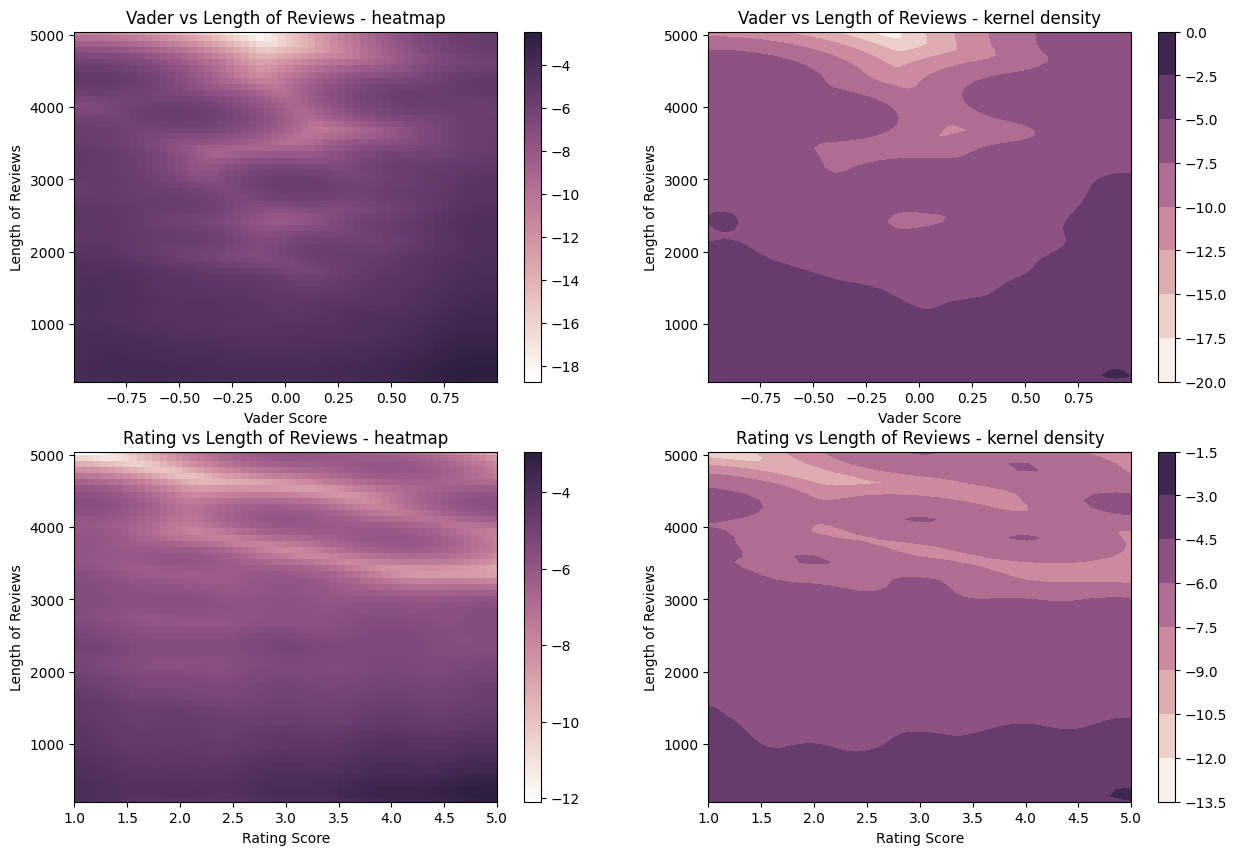

In [104]:
k1 = gaussian_kde(np.vstack([vader_scores, review_lens]))
review_lens = np.array(review_lens)
xi1, yi1 = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,review_lens.min():review_lens.max():review_lens.size**0.5*1j]
zi1 = k1(np.vstack([xi1.flatten(), yi1.flatten()]))

k2 = gaussian_kde(np.vstack([rating_scores, review_lens]))
xi2, yi2 = np.mgrid[rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j,review_lens.min():review_lens.max():review_lens.size**0.5*1j]
zi2 = k2(np.vstack([xi2.flatten(), yi2.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))

b1 = ax1.pcolormesh(xi1, yi1, np.log10(zi1.reshape(xi1.shape)), cmap=cmap)
b2 = ax2.contourf(xi1, yi1, np.log10(zi1.reshape(xi1.shape)), cmap=cmap)
b3 = ax3.pcolormesh(xi2, yi2, np.log10(zi2.reshape(xi2.shape)), cmap=cmap)
b4 = ax4.contourf(xi2, yi2, np.log10(zi2.reshape(xi2.shape)), cmap=cmap)

ax1.set_xlim(vader_scores.min(), vader_scores.max())
ax1.set_ylim(review_lens.min(), review_lens.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(review_lens.min(), review_lens.max())
ax3.set_xlim(rating_scores.min(), rating_scores.max())
ax3.set_ylim(review_lens.min(), review_lens.max())
ax4.set_xlim(rating_scores.min(), rating_scores.max())
ax4.set_ylim(review_lens.min(), review_lens.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Length of Reviews')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Length of Reviews')

ax3.set_xlabel('Rating Score')
ax3.set_ylabel('Length of Reviews')

ax4.set_xlabel('Rating Score')
ax4.set_ylabel('Length of Reviews')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)
fig.colorbar(b3, ax=ax3)
fig.colorbar(b4, ax=ax4)

ax1.set_title('Vader vs Length of Reviews - heatmap')
ax2.set_title('Vader vs Length of Reviews - kernel density');
ax3.set_title('Rating vs Length of Reviews - heatmap')
ax4.set_title('Rating vs Length of Reviews - kernel density');

If someone is deemed neutral (vader = 0), they will write less (darkest along column 0 is on bottom). If someone writes a lot, they are darkest near the 3 extremes.

## (iii)

In [105]:
avg_df.columns

Index(['avg_vader', 'median_vader', 'avg_ratingScore', 'total_reviews'], dtype='object')

Text(0, 0.5, 'number of reviews')

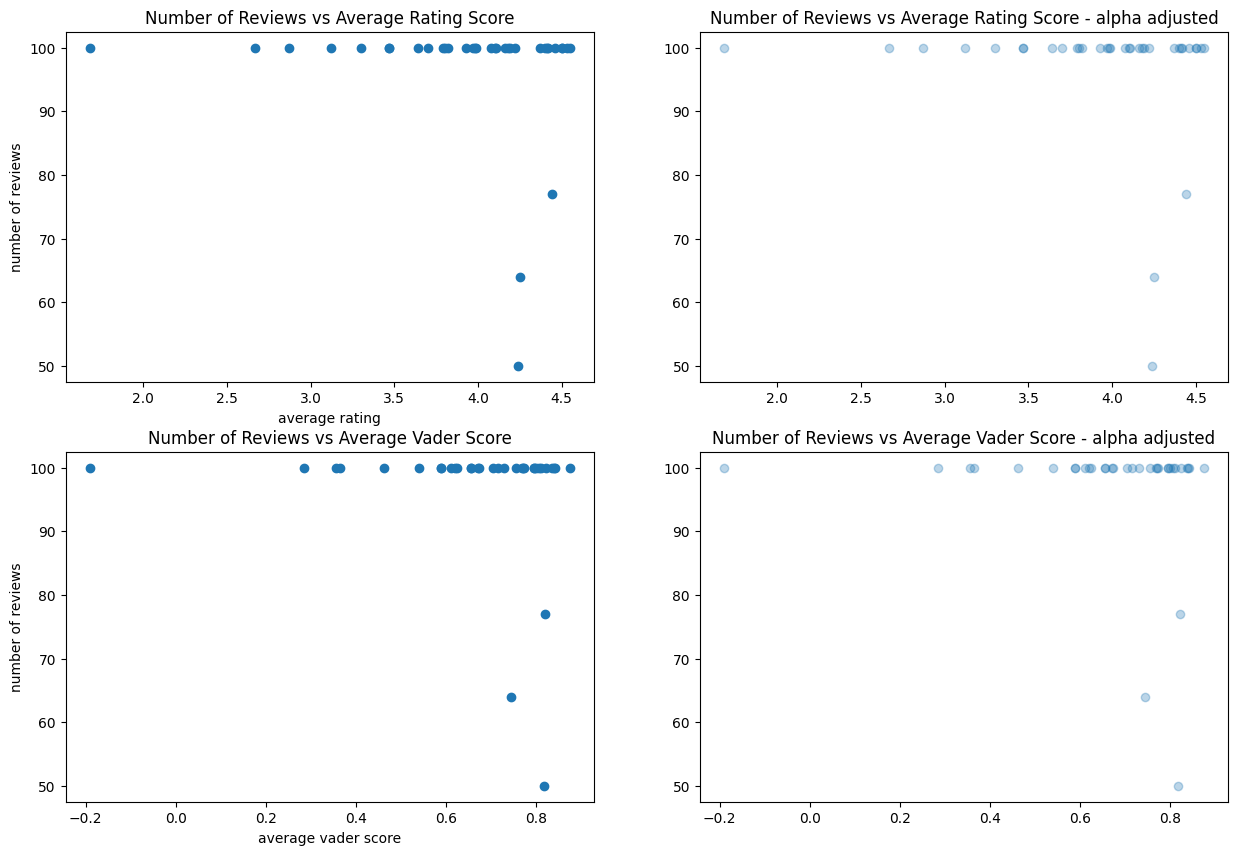

In [106]:
fig, ax = plt.subplots(2,2,figsize=(15,10),sharex=False,sharey=False)
avg_rating_scores = avg_df['avg_ratingScore'].values
avg_vader_scores = avg_df['avg_vader'].values
num_reviews = avg_df['total_reviews'].values

ax[0,0].plot(avg_rating_scores, num_reviews, "o")
ax[0,1].plot(avg_rating_scores, num_reviews, "o", alpha=0.3)
ax[1,0].plot(avg_vader_scores, num_reviews, "o")
ax[1,1].plot(avg_vader_scores, num_reviews, "o", alpha=0.3)

ax[0,0].set_title('Number of Reviews vs Average Rating Score')
ax[0,0].set_xlabel('average rating')
ax[0,0].set_ylabel('number of reviews')

ax[0,1].set_title('Number of Reviews vs Average Rating Score - alpha adjusted')
ax[0,0].set_xlabel('average rating')
ax[0,0].set_ylabel('number of reviews')

ax[1,0].set_title('Number of Reviews vs Average Vader Score')
ax[1,0].set_xlabel('average vader score')
ax[1,0].set_ylabel('number of reviews')

ax[1,1].set_title('Number of Reviews vs Average Vader Score - alpha adjusted')
ax[1,0].set_xlabel('average vader score')
ax[1,0].set_ylabel('number of reviews')

There is a lack of trends as I capped num of reviews to 100. However, we see the hotels without 100 reviews have vader of less than 4.5, which means there actual rating is around 4. This makes sense as the reviewers like the hotel but don't like it that much to maybe leave a positive comment.

## Q5d

In [107]:
def make_address(row):
  # individual columns need to be combined
  return row['streetAddress']+", "+row['City']+", "+row['Province']

In [108]:
# Need the location for each hotel in a format the tool can handle

geo_rating_df = avg_df\
                         .join(hotelDf.groupby('hotelName')\
                         .agg({'streetAddress':'max','City':'max','Province':'max','postalCode':'max'}))
geo_rating_df['formed_address'] = geo_rating_df.apply(make_address , axis=1)

In [109]:
# 0 - need to give the tool a generic name.
locator = Photon(user_agent='myGeocoder')
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2 - form the location string
geo_rating_df['location'] = geo_rating_df['formed_address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
geo_rating_df['point'] = geo_rating_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
geo_rating_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(geo_rating_df['point'].tolist(), index=geo_rating_df.index)

geo_rating_df.head()

avg_vader  median_vader  avg_ratingScore  total_reviews             streetAddress          City Province postalCode                                   formed_address                                                                                                                                                         location                                           point   latitude   longitude  altitude
hotelName                                                                                                                                                                                                                                                                                                                                                                                                                                                      
Acclaim Hotel Calgary Airport             0.705338       0.92825         4.190000            100      123 Freeport Blvd NE  ('Calgary',)  Alberta    T3N 0A3      123 Freeport Blvd NE, ('Calgary',), Alberta                                                                                 (Freeport Way NE, T3J 4X7, Calgary, Alberta, Canada, (51.1506232, -114.0097374))                 (51.1506232, -114.0097374, 0.0)  51.150623 -114.009737       0.0
Alt Hotel Calgary East Village            0.821145       0.94880         4.441558             77     635 Confluence Way SE  ('Calgary',)  Alberta    T2G 1C3     635 Confluence Way SE, ('Calgary',), Alberta                                                                                (Confluence Way SE, T2G 1C3, Calgary, Alberta, Canada, (51.047545, -114.0491006))                  (51.047545, -114.0491006, 0.0)  51.047545 -114.049101       0.0
Amenida Residences                        0.655677       0.92055         3.640000            100  4206 Macleod Trail South  ('Calgary',)  Alberta    T2G 2R7  4206 Macleod Trail South, ('Calgary',), Alberta                                                                                (Calgary Trail South, Alberta, Canada, (53.468042499999996, -113.49385312851027))  (53.468042499999996, -113.49385312851027, 0.0)  53.468042 -113.493853       0.0
Best Western Plus Calgary Centre Inn      0.755501       0.93980         4.460000            100     3630 Macleod Trail SE  ('Calgary',)  Alberta    T2G 2P9     3630 Macleod Trail SE, ('Calgary',), Alberta                                                                                (Macleod Trail SE, T2G 4X3, Calgary, Alberta, Canada, (51.0505264, -114.0577587))                 (51.0505264, -114.0577587, 0.0)  51.050526 -114.057759       0.0
Best Western Plus Port O&#39;Call Hotel   0.623664       0.91605         3.800000            100     1935 McKnight Blvd NE  ('Calgary',)  Alberta    T2E 6V4     1935 McKnight Blvd NE, ('Calgary',), Alberta  (BEST WESTERN PLUS Port O' Call Hotel, 1935, McKnight Boulevard NE, T2N 6V4, McKnight Boulevard NE, Calgary, Alberta, Canada, (51.091228, -114.01255583301644))           (51.091228, -114.01255583301644, 0.0)  51.091228 -114.012556       0.0

In [110]:
# Code snippet: https://stackoverflow.com/questions/71336227/setting-a-color-using-an-attribute-folium-python-dataframe

import branca.colormap as cm
linear = cm.LinearColormap(["red", "green"], vmin=geo_rating_df['avg_ratingScore'].min(), vmax=geo_rating_df['avg_ratingScore'].max())

map1 = folium.Map(
    location=[geo_rating_df['latitude'].mean(), geo_rating_df['longitude'].mean()], # <- this will need to be set based on your own hotels
    tiles='cartodbpositron',
    zoom_start=8,
)

geo_rating_df.dropna().apply(lambda row: folium.CircleMarker([row['latitude'], row['longitude']],
                      popup=row.name+': '+str(row['avg_ratingScore']),
                      radius=10,
                      color = linear(row['avg_ratingScore']),
                      ).add_to(map1), axis=1)

map1

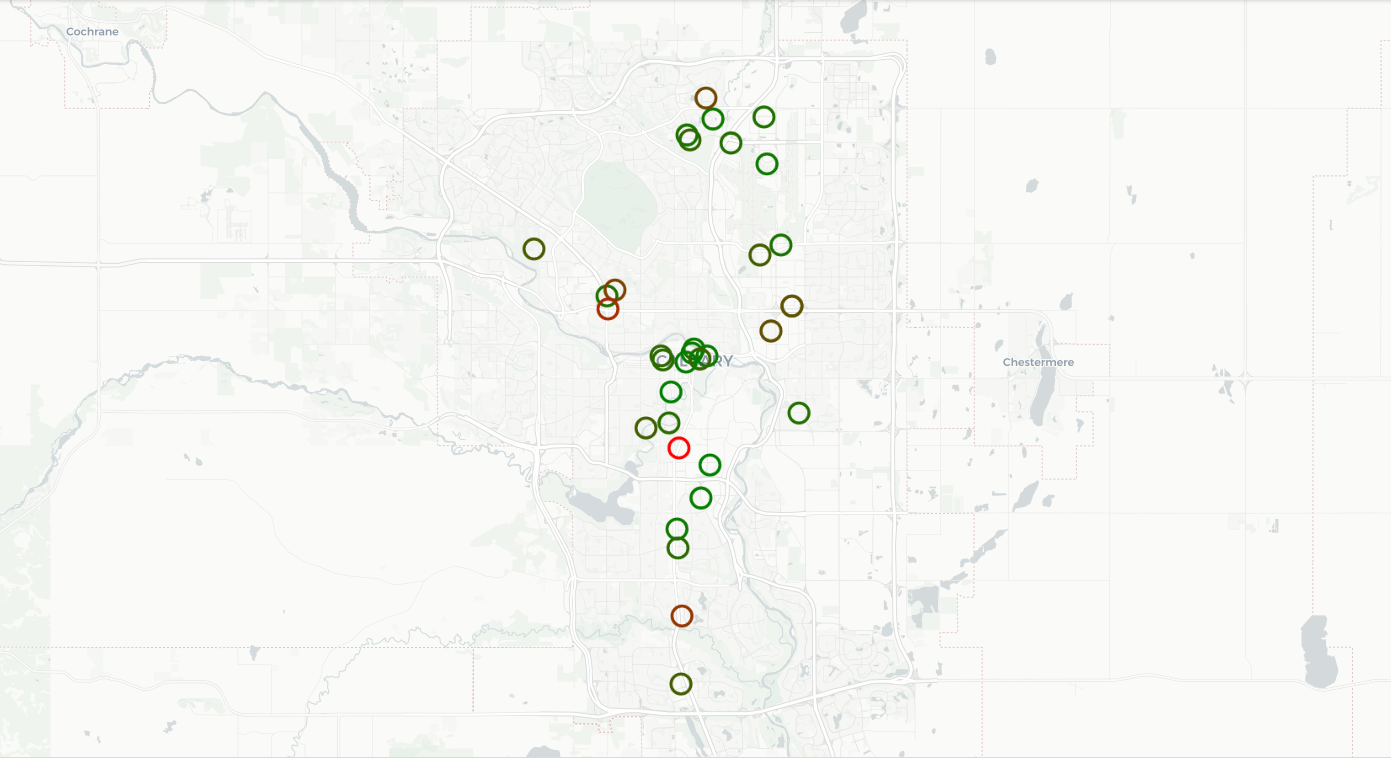

In [111]:
from IPython.display import Image
Image('map.png')

I would recommend not going to the red areas. There is a concentration of green circles at the middle. I would recommend going here.

## Q5e

Residence Inn by Marriott Calgary Downtown / Beltline District
Hotel Blackfoot
Canadas Best Value Inn Calgary Chinook Station
Econo Lodge Motel Village
SureStay Plus By Best Western Calgary South East
The Westin Calgary


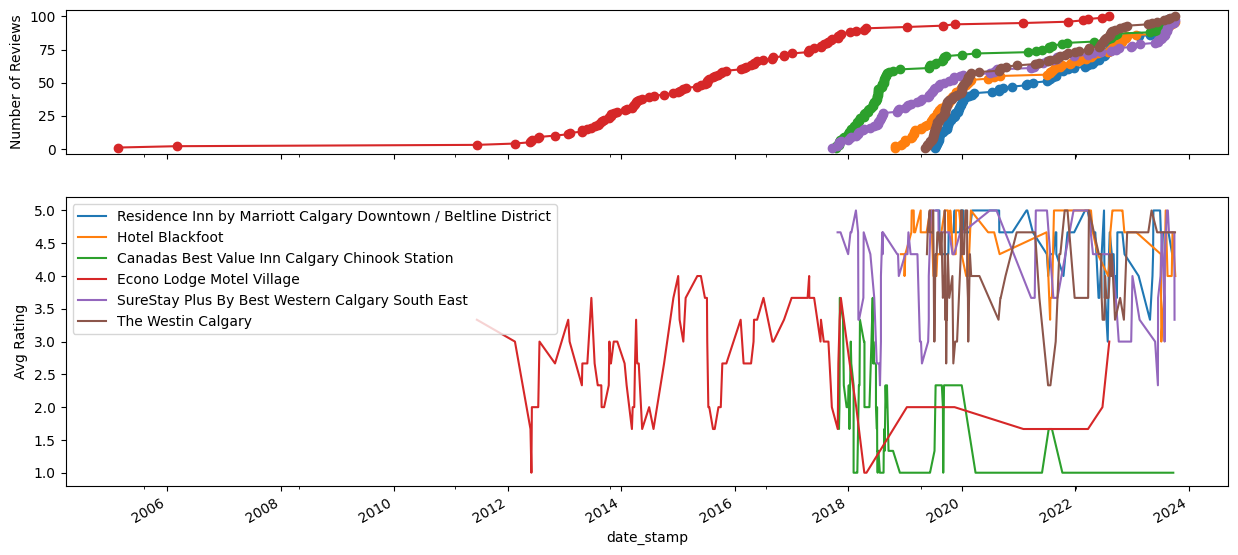

In [112]:
hotels = ['Residence Inn by Marriott Calgary Downtown / Beltline District', 'Hotel Blackfoot', 'Canadas Best Value Inn Calgary Chinook Station', 'Econo Lodge Motel Village', 'SureStay Plus By Best Western Calgary South East', 'The Westin Calgary']

# It can be useful to see when reviews were being made and how the ratings changed using a running mean
fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})

for hotel in hotels:
  print(hotel)
  _df = hotelDf[hotelDf['hotelName']==hotel]
  _df = _df[~_df['date_stamp'].str.contains('ago')]
  _df = _df.set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df['count'].cumsum().plot(ax=ax[0],label=hotel, marker='o')
  _df['ratingScore'].rolling(3).mean().plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('Avg Rating')
ax[0].set_ylabel('Number of Reviews')
plt.legend()

Residence Inn by Marriott Calgary Downtown / Beltline District
Econo Lodge Motel Village


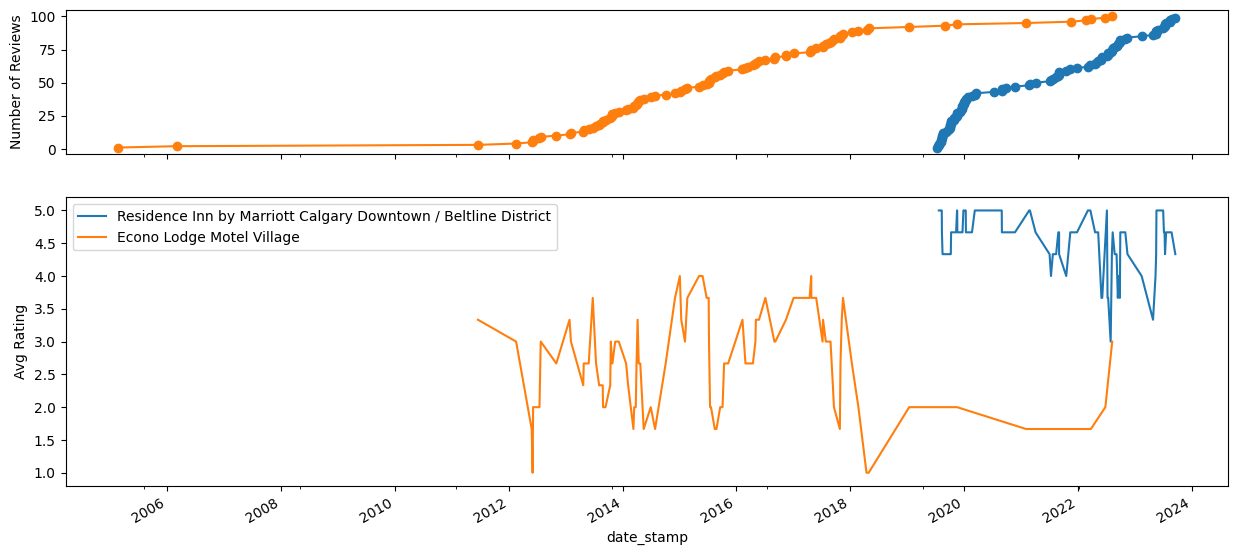

In [113]:
hotels = ['Residence Inn by Marriott Calgary Downtown / Beltline District', 'Econo Lodge Motel Village']

# It can be useful to see when reviews were being made and how the ratings changed using a running mean
fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})

for hotel in hotels:
  print(hotel)
  _df = hotelDf[hotelDf['hotelName']==hotel]
  _df = _df[~_df['date_stamp'].str.contains('ago')]
  _df = _df.set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df['count'].cumsum().plot(ax=ax[0],label=hotel, marker='o')
  _df['ratingScore'].rolling(3).mean().plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('Avg Rating')
ax[0].set_ylabel('Number of Reviews')
plt.legend()

Highly rated and lowly rated hotels both fluctuate over time, but highly fluctuates around 4-5 and low around 1-4.

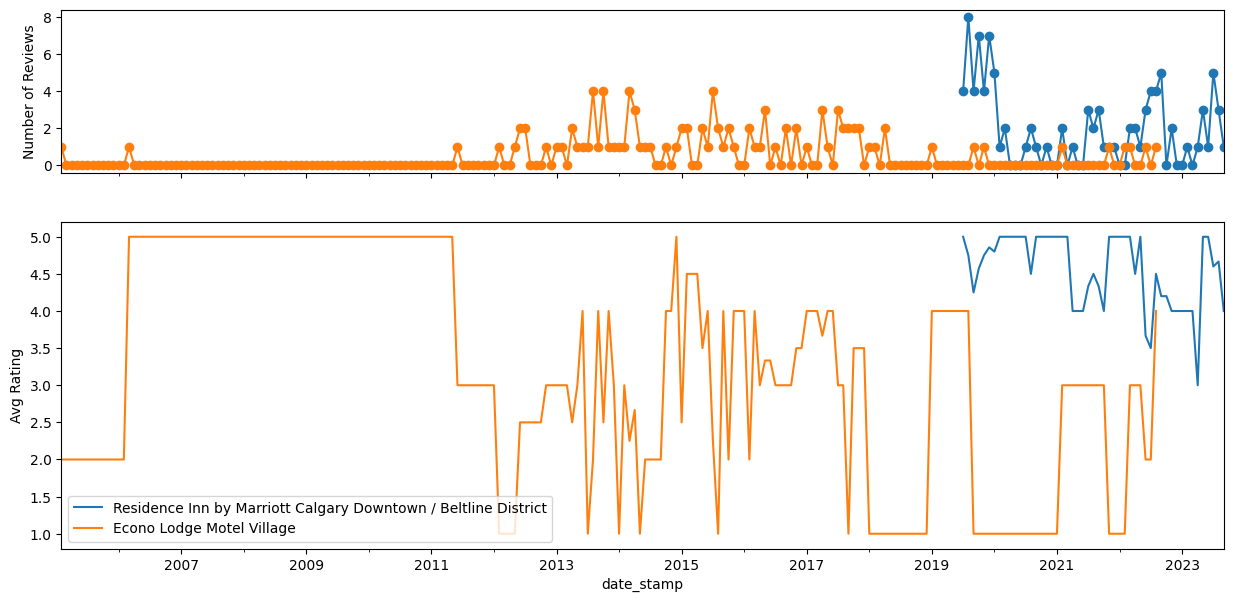

In [114]:
# It can be useful to see when reviews were being made and how the ratings changed
fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})

for hotel in hotels:
  _df = hotelDf[hotelDf['hotelName']==hotel]
  _df = _df[~_df['date_stamp'].str.contains('ago')]
  _df = _df.set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df_monthly = _df.groupby(pd.Grouper(freq='M')).agg({'count':'sum','ratingScore':'mean'})
  _df_monthly['ratingScore'] = _df_monthly['ratingScore'].fillna(method='ffill') # hold the last rating constant in months with no reviews
  _df_monthly['count'].plot(ax=ax[0],label=hotel, marker='o')
  _df_monthly['ratingScore'].plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('Avg Rating')
ax[0].set_ylabel('Number of Reviews')
plt.legend()

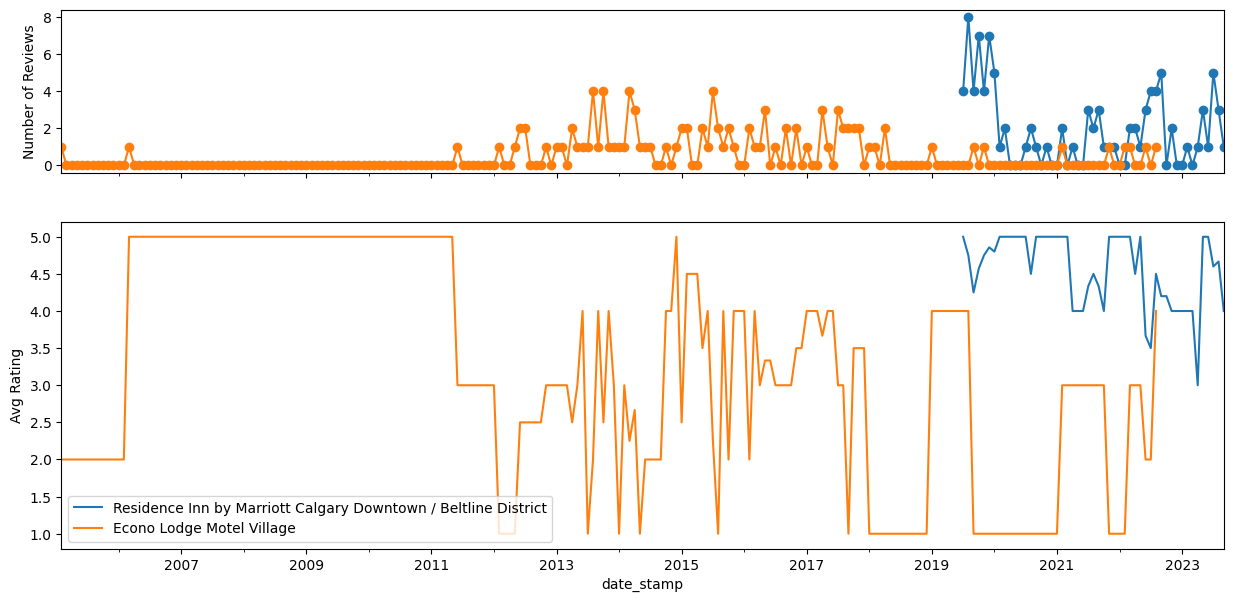

In [115]:
hotels = ['Residence Inn by Marriott Calgary Downtown / Beltline District', 'Econo Lodge Motel Village']

# It can be useful to see when reviews were being made and how the ratings changed
fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})

for hotel in hotels:
  _df = hotelDf[hotelDf['hotelName']==hotel]
  _df = _df[~_df['date_stamp'].str.contains('ago')]
  _df = _df.set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df_monthly = _df.groupby(pd.Grouper(freq='M')).agg({'count':'sum','ratingScore':'mean'})
  _df_monthly['ratingScore'] = _df_monthly['ratingScore'].fillna(method='ffill') # hold the last rating constant in months with no reviews
  _df_monthly['count'].plot(ax=ax[0],label=hotel, marker='o')
  _df_monthly['ratingScore'].plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('Avg Rating')
ax[0].set_ylabel('Number of Reviews')
plt.legend()

I plot monthly average rating. The fixed time period is 1 month. Again, there is alrge fluctuations in the worst hotel, maybe due to staff changes. The rapid fluctuations indicate inconsistencies- specifically, maybe with customer service and building status. Meanwhile, less fluctuations with best hotel. There are still some decreases, but maybe they take reviews in to account and so they go back up.